# League of Legends Match Data Analysis

This notebook analyzes the Kaggle LoL Match Dataset (2025) to uncover patterns and statistics that back up scouting report insights.

**Key analyses:**
- Champion win rates and pick rates
- Role-specific performance metrics
- Draft patterns and synergies
- Game duration and tempo analysis
- Objective correlations with wins
- Meta evolution and trends

## 1. Setup & Data Loading

In [75]:
# Install dependencies if needed
# !pip install kagglehub pandas numpy matplotlib seaborn scikit-learn plotly openpyxl

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Ensure openpyxl is available for Excel files
try:
    import openpyxl
except ImportError:
    print("Installing openpyxl for Excel support...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'openpyxl'])
    import openpyxl

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# For interactive plots (optional)
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    HAS_PLOTLY = True
except ImportError:
    HAS_PLOTLY = False
    print("Plotly not available - using matplotlib only")

print("Libraries loaded successfully!")

Plotly not available - using matplotlib only
Libraries loaded successfully!


In [76]:
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("jakubkrasuski/league-of-legends-match-dataset-2025")
print("Path to dataset files:", path)

# List available files
data_path = Path(path)
print("\nAvailable files:")
for f in data_path.rglob("*"):
    if f.is_file():
        size_mb = f.stat().st_size / (1024 * 1024)
        print(f"  {f.name}: {size_mb:.2f} MB")

Path to dataset files: /Users/daniill/.cache/kagglehub/datasets/jakubkrasuski/league-of-legends-match-dataset-2025/versions/1

Available files:
  league_data.xlsx: 19.44 MB


In [77]:
# Load the main dataset(s)
# This dataset is an Excel file (.xlsx)

csv_files = list(data_path.rglob("*.csv"))
parquet_files = list(data_path.rglob("*.parquet"))
json_files = list(data_path.rglob("*.json"))
excel_files = list(data_path.rglob("*.xlsx")) + list(data_path.rglob("*.xls"))

print(f"Found {len(csv_files)} CSV, {len(parquet_files)} Parquet, {len(json_files)} JSON, {len(excel_files)} Excel files")

# Load primary data file (prioritize Excel for this dataset)
if excel_files:
    main_file = excel_files[0]
    print(f"\nLoading {main_file.name}...")
    # For large Excel files, this may take a moment
    df = pd.read_excel(main_file, engine='openpyxl')
elif csv_files:
    main_file = csv_files[0]
    print(f"\nLoading {main_file.name}...")
    df = pd.read_csv(main_file)
elif parquet_files:
    main_file = parquet_files[0]
    print(f"\nLoading {main_file.name}...")
    df = pd.read_parquet(main_file)
else:
    raise FileNotFoundError("No supported data files found in dataset")

print(f"\nDataset shape: {df.shape}")
print(f"Columns ({len(df.columns)}):")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

Found 0 CSV, 0 Parquet, 0 JSON, 1 Excel files

Loading league_data.xlsx...

Dataset shape: (40410, 94)
Columns (94):
  1. game_id
  2. game_start_utc
  3. game_duration
  4. game_mode
  5. game_type
  6. game_version
  7. map_id
  8. platform_id
  9. queue_id
  10. participant_id
  11. puuid
  12. summoner_name
  13. summoner_id
  14. summoner_level
  15. champion_id
  16. champion_name
  17. team_id
  18. win
  19. individual_position
  20. team_position
  21. lane
  22. role
  23. kills
  24. deaths
  25. assists
  26. baron_kills
  27. dragon_kills
  28. gold_earned
  29. gold_spent
  30. total_damage_dealt
  31. total_damage_dealt_to_champions
  32. physical_damage_dealt_to_champions
  33. magic_damage_dealt_to_champions
  34. true_damage_dealt_to_champions
  35. damage_dealt_to_objectives
  36. damage_dealt_to_turrets
  37. total_damage_taken
  38. physical_damage_taken
  39. magic_damage_taken
  40. true_damage_taken
  41. time_ccing_others
  42. vision_score
  43. wards_placed
 

In [78]:
# Basic data exploration
print("=" * 60)
print("DATA OVERVIEW")
print("=" * 60)

print("\nFirst few rows:")
display(df.head())

print("\nData types:")
print(df.dtypes)

print("\nBasic statistics:")
display(df.describe())

print("\nMissing values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing'] > 0])

DATA OVERVIEW

First few rows:


,game_id,game_start_utc,game_duration,game_mode,game_type,game_version,map_id,platform_id,queue_id,participant_id,...,final_magicPen,final_magicPenPercent,final_magicResist,final_movementSpeed,final_omnivamp,final_physicalVamp,final_power,final_powerMax,final_powerRegen,final_spellVamp
0,3727443167,2025-01-15 14:56:00,1714,CLASSIC,MATCHED_GAME,15.1.649.4112,11,EUN1,420,5,...,0,0,48,385,0,0,799,1134,147,0
1,3726377460,2025-01-13 10:50:00,1300,CLASSIC,MATCHED_GAME,15.1.648.3927,11,EUN1,420,5,...,0,0,38,390,0,0,970,970,105,0
2,3729643655,2025-01-19 18:15:00,2019,CLASSIC,MATCHED_GAME,15.1.649.4112,11,EUN1,420,2,...,0,0,121,431,0,0,10000,10000,0,0
3,3729915593,2025-01-20 01:27:00,1625,CLASSIC,MATCHED_GAME,15.1.649.4112,11,EUN1,420,8,...,12,0,47,380,0,0,1122,1596,37,0
4,3729901665,2025-01-20 00:40:00,1542,CLASSIC,MATCHED_GAME,15.1.649.4112,11,EUN1,420,10,...,0,0,40,534,0,0,1025,1025,109,0



Data types:
game_id                        int64
game_start_utc        datetime64[ns]
game_duration                  int64
game_mode                     object
game_type                     object
                           ...      
final_physicalVamp             int64
final_power                    int64
final_powerMax                 int64
final_powerRegen               int64
final_spellVamp                int64
Length: 94, dtype: object

Basic statistics:


,game_id,game_start_utc,game_duration,map_id,queue_id,participant_id,summoner_level,champion_id,team_id,kills,...,final_magicPen,final_magicPenPercent,final_magicResist,final_movementSpeed,final_omnivamp,final_physicalVamp,final_power,final_powerMax,final_powerRegen,final_spellVamp
count,4.041000e+04,40410,40410.000000,40410.000000,40410.000000,40410.000000,40410.000000,40410.000000,40410.000000,40410.000000,...,40410.000000,40410.00000,40410.000000,40410.000000,40410.000000,40410.0,40410.000000,40410.000000,40410.000000,40410.000000
mean,3.725500e+09,2025-01-11 21:39:50.111358720,1581.655902,11.240782,430.002475,5.498144,393.328904,176.765429,149.962880,7.274091,...,5.653724,1.92638,71.650408,405.431106,0.043702,0.0,1024.290572,1257.735659,61.021975,0.005593
min,3.551580e+09,2024-02-17 16:03:00,101.000000,11.000000,400.000000,1.000000,2.000000,1.000000,100.000000,0.000000,...,0.000000,0.00000,-3.000000,129.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,3.727229e+09,2025-01-14 22:39:00,1277.000000,11.000000,420.000000,3.000000,201.000000,45.000000,100.000000,3.000000,...,0.000000,0.00000,48.000000,380.000000,0.000000,0.0,496.000000,783.000000,30.000000,0.000000
50%,3.728683e+09,2025-01-17 22:44:00,1618.000000,11.000000,420.000000,5.000000,360.000000,99.000000,100.000000,6.000000,...,0.000000,0.00000,54.000000,395.000000,0.000000,0.0,845.000000,1038.000000,41.000000,0.000000
75%,3.729385e+09,2025-01-19 08:19:00,1883.000000,11.000000,450.000000,8.000000,544.000000,203.000000,200.000000,10.000000,...,12.000000,0.00000,81.000000,415.000000,0.000000,0.0,1257.000000,1570.000000,67.000000,0.000000
max,3.730264e+09,2025-01-20 21:16:00,3307.000000,12.000000,890.000000,10.000000,2065.000000,950.000000,200.000000,48.000000,...,49.000000,48.00000,515.000000,1193.000000,25.000000,0.0,10000.000000,10000.000000,1013.000000,26.000000
std,1.755725e+07,NaN,477.051611,0.427563,22.964271,2.872316,251.874061,222.688428,50.000605,5.799235,...,11.022641,7.22606,38.658925,45.587867,0.674440,0.0,1209.163188,1207.966365,62.263617,0.376588



Missing values:
                                       Missing  Percentage
summoner_name                             2308        5.71
team_position                             9748       24.12
solo_tier                                12544       31.04
solo_rank                                12544       31.04
solo_lp                                  12544       31.04
solo_wins                                12544       31.04
solo_losses                              12544       31.04
flex_tier                                30047       74.36
flex_rank                                30047       74.36
flex_lp                                  30047       74.36
flex_wins                                30047       74.36
flex_losses                              30047       74.36
champion_mastery_level                      30        0.07
champion_mastery_points                     30        0.07
champion_mastery_lastPlayTime               30        0.07
champion_mastery_lastPlayTime_utc      

## 2. Champion Analysis

Analyzing champion pick rates, win rates, and meta trends.

In [79]:
# Champion statistics - adjust column names based on actual dataset
# Common column patterns: 'champion', 'championName', 'champion_name', 'champ'

# Detect champion column
champ_cols = [c for c in df.columns if 'champ' in c.lower()]
win_cols = [c for c in df.columns if 'win' in c.lower() or 'result' in c.lower()]

print("Potential champion columns:", champ_cols)
print("Potential win columns:", win_cols)

# Use first found or adjust manually
CHAMP_COL = champ_cols[0] if champ_cols else None
WIN_COL = win_cols[0] if win_cols else None

if CHAMP_COL and WIN_COL:
    # Calculate champion stats
    champ_stats = df.groupby(CHAMP_COL).agg(
        games=('match_id' if 'match_id' in df.columns else CHAMP_COL, 'count'),
        wins=(WIN_COL, lambda x: (x == True).sum() if x.dtype == bool else x.sum())
    ).reset_index()
    
    champ_stats['winrate'] = (champ_stats['wins'] / champ_stats['games'] * 100).round(2)
    champ_stats['pickrate'] = (champ_stats['games'] / len(df) * 100).round(2)
    champ_stats = champ_stats.sort_values('games', ascending=False)
    
    print(f"\nTotal unique champions: {len(champ_stats)}")
    print("\nTop 20 Most Picked Champions:")
    display(champ_stats.head(20))
else:
    print("Could not auto-detect champion/win columns. Please set manually.")

Potential champion columns: ['champion_id', 'champion_name', 'total_damage_dealt_to_champions', 'physical_damage_dealt_to_champions', 'magic_damage_dealt_to_champions', 'true_damage_dealt_to_champions', 'champion_mastery_level', 'champion_mastery_points', 'champion_mastery_lastPlayTime', 'champion_mastery_lastPlayTime_utc', 'champion_mastery_pointsSinceLastLevel', 'champion_mastery_pointsUntilNextLevel', 'champion_mastery_tokensEarned']
Potential win columns: ['win', 'solo_wins', 'flex_wins']

Total unique champions: 169

Top 20 Most Picked Champions:


,champion_id,games,wins,winrate,pickrate
47,51,751,378,50.33,1.86
20,21,713,365,51.19,1.76
125,222,678,346,51.03,1.68
83,99,663,358,54.00,1.64
122,202,633,340,53.71,1.57
97,117,540,265,49.07,1.34
71,81,520,266,51.15,1.29
128,234,520,257,49.42,1.29
93,112,478,229,47.91,1.18
57,62,454,243,53.52,1.12


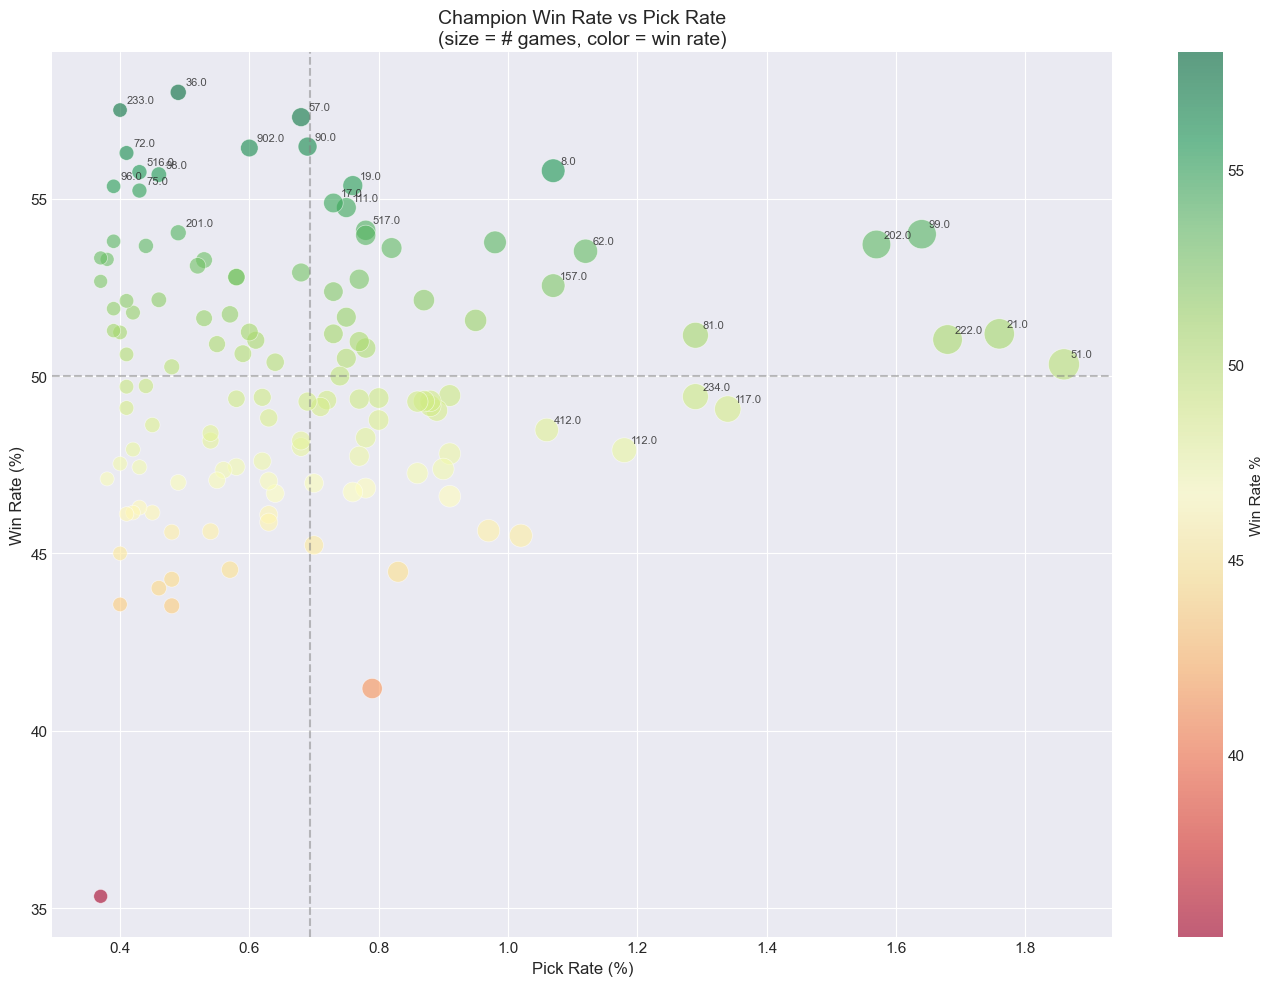


Plot saved as 'champion_winrate_pickrate.png'


In [80]:
# Champion Win Rate vs Pick Rate scatter plot

if 'champ_stats' in dir() and len(champ_stats) > 0:
    # Filter to champions with significant sample size
    MIN_GAMES = max(50, champ_stats['games'].quantile(0.25))
    plot_data = champ_stats[champ_stats['games'] >= MIN_GAMES].copy()
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Create scatter plot
    scatter = ax.scatter(
        plot_data['pickrate'],
        plot_data['winrate'],
        s=plot_data['games'] / plot_data['games'].max() * 500,
        alpha=0.6,
        c=plot_data['winrate'],
        cmap='RdYlGn',
        edgecolors='white',
        linewidth=0.5
    )
    
    # Add reference lines
    ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% WR')
    avg_pickrate = plot_data['pickrate'].mean()
    ax.axvline(x=avg_pickrate, color='gray', linestyle='--', alpha=0.5)
    
    # Label outliers (high WR + high PR or very high WR)
    for idx, row in plot_data.iterrows():
        if row['winrate'] > 54 or (row['pickrate'] > plot_data['pickrate'].quantile(0.9)):
            ax.annotate(
                row[CHAMP_COL],
                (row['pickrate'], row['winrate']),
                fontsize=8,
                alpha=0.8,
                xytext=(5, 5),
                textcoords='offset points'
            )
    
    ax.set_xlabel('Pick Rate (%)', fontsize=12)
    ax.set_ylabel('Win Rate (%)', fontsize=12)
    ax.set_title('Champion Win Rate vs Pick Rate\n(size = # games, color = win rate)', fontsize=14)
    
    plt.colorbar(scatter, label='Win Rate %')
    plt.tight_layout()
    plt.savefig('champion_winrate_pickrate.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPlot saved as 'champion_winrate_pickrate.png'")

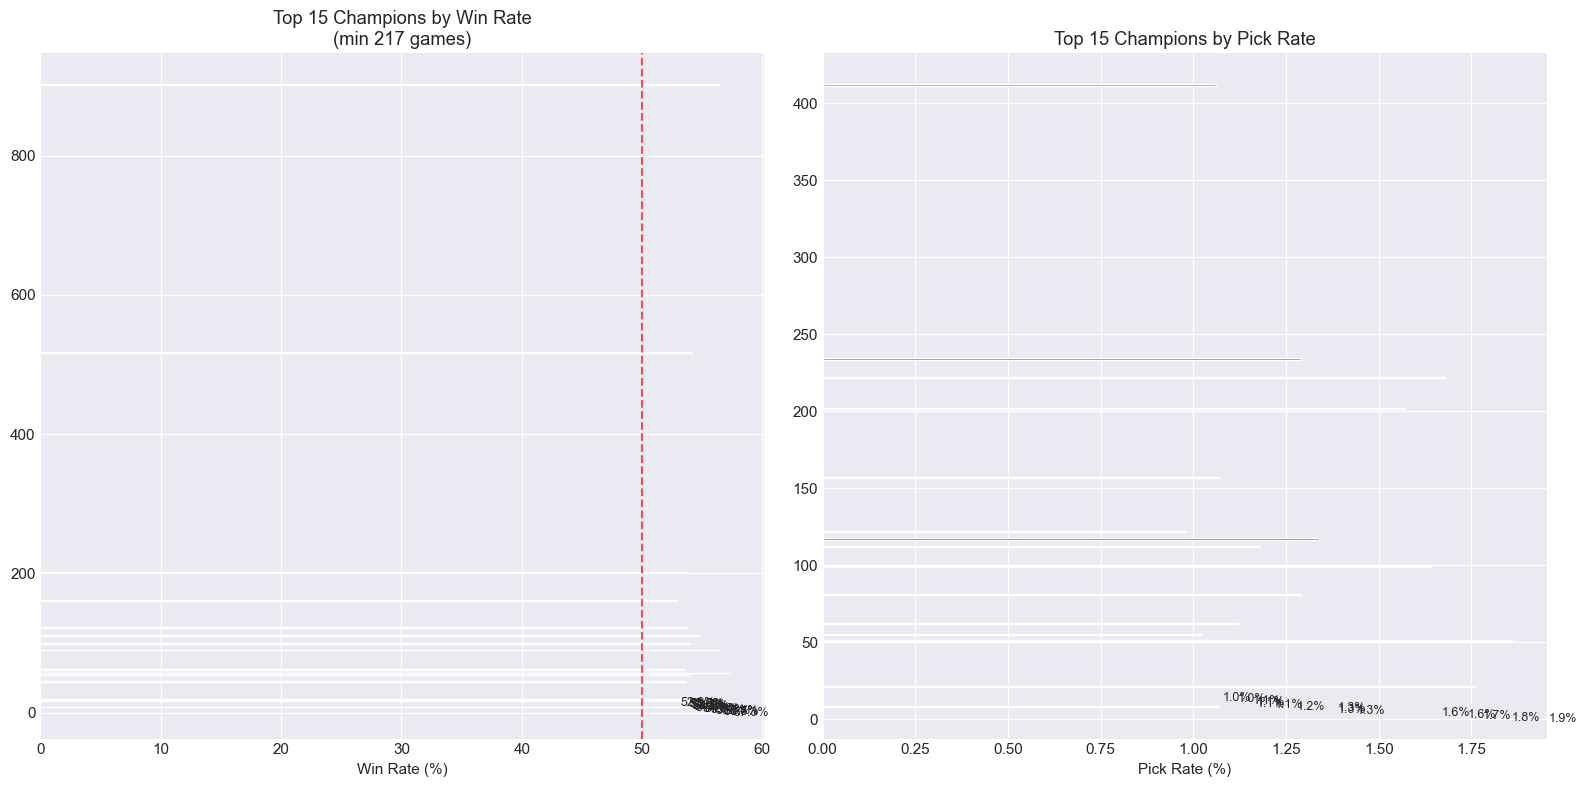

In [81]:
# Top Champions by Win Rate (with minimum games)

if 'champ_stats' in dir():
    MIN_GAMES = max(100, champ_stats['games'].quantile(0.5))
    reliable_champs = champ_stats[champ_stats['games'] >= MIN_GAMES].copy()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top Win Rate
    top_wr = reliable_champs.nlargest(15, 'winrate')
    colors_wr = plt.cm.RdYlGn((top_wr['winrate'] - 45) / 20)
    axes[0].barh(top_wr[CHAMP_COL], top_wr['winrate'], color=colors_wr, edgecolor='white')
    axes[0].set_xlabel('Win Rate (%)')
    axes[0].set_title(f'Top 15 Champions by Win Rate\n(min {int(MIN_GAMES)} games)')
    axes[0].axvline(x=50, color='red', linestyle='--', alpha=0.7)
    for i, (idx, row) in enumerate(top_wr.iterrows()):
        axes[0].text(row['winrate'] + 0.3, i, f"{row['winrate']:.1f}%", va='center', fontsize=9)
    
    # Top Pick Rate
    top_pr = reliable_champs.nlargest(15, 'pickrate')
    colors_pr = plt.cm.Blues(top_pr['pickrate'] / top_pr['pickrate'].max())
    axes[1].barh(top_pr[CHAMP_COL], top_pr['pickrate'], color=colors_pr, edgecolor='white')
    axes[1].set_xlabel('Pick Rate (%)')
    axes[1].set_title('Top 15 Champions by Pick Rate')
    for i, (idx, row) in enumerate(top_pr.iterrows()):
        axes[1].text(row['pickrate'] + 0.1, i, f"{row['pickrate']:.1f}%", va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('top_champions.png', dpi=150, bbox_inches='tight')
    plt.show()

## 3. Role-Based Analysis

Performance metrics broken down by role (Top, Jungle, Mid, Bot, Support).

In [82]:
# Role detection and analysis
role_cols = [c for c in df.columns if 'role' in c.lower() or 'position' in c.lower() or 'lane' in c.lower()]
print("Potential role columns:", role_cols)

ROLE_COL = role_cols[0] if role_cols else None

if ROLE_COL:
    print(f"\nUsing role column: {ROLE_COL}")
    print(f"\nRole distribution:")
    print(df[ROLE_COL].value_counts())
    
    # Role-based statistics
    kda_cols = [c for c in df.columns if any(x in c.lower() for x in ['kill', 'death', 'assist', 'kda'])]
    print(f"\nKDA-related columns: {kda_cols}")

Potential role columns: ['individual_position', 'team_position', 'lane', 'role']

Using role column: individual_position

Role distribution:
individual_position
Invalid    9748
JUNGLE     6191
BOTTOM     6132
TOP        6130
MIDDLE     6121
UTILITY    6088
Name: count, dtype: int64

KDA-related columns: ['kills', 'deaths', 'assists', 'baron_kills', 'dragon_kills', 'wards_killed', 'final_attackDamage']



Role Performance (avg per game):


,kills,deaths,assists,KDA
individual_position,,,,
BOTTOM,7.87,6.12,6.64,2.37
Invalid,11.19,11.21,25.56,3.28
JUNGLE,6.88,6.07,8.32,2.50
MIDDLE,6.92,5.94,6.80,2.31
TOP,5.71,6.02,5.55,1.87
UTILITY,2.74,6.06,13.64,2.70


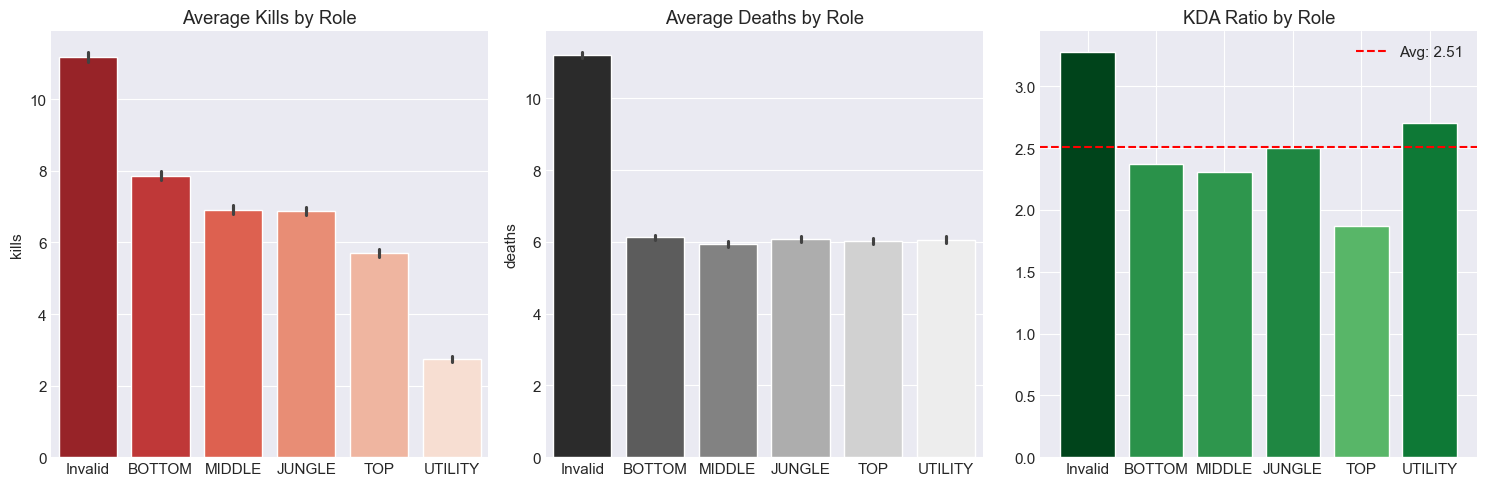

In [83]:
# Role performance visualization

if ROLE_COL and WIN_COL:
    role_stats = df.groupby(ROLE_COL).agg(
        games=(ROLE_COL, 'count'),
        wins=(WIN_COL, lambda x: (x == True).sum() if x.dtype == bool else x.sum())
    ).reset_index()
    role_stats['winrate'] = (role_stats['wins'] / role_stats['games'] * 100).round(2)
    
    # Look for KDA columns
    kill_col = [c for c in df.columns if 'kill' in c.lower() and 'assist' not in c.lower()]
    death_col = [c for c in df.columns if 'death' in c.lower()]
    assist_col = [c for c in df.columns if 'assist' in c.lower()]
    
    if kill_col and death_col and assist_col:
        KILL_COL = kill_col[0]
        DEATH_COL = death_col[0]
        ASSIST_COL = assist_col[0]
        
        role_kda = df.groupby(ROLE_COL).agg({
            KILL_COL: 'mean',
            DEATH_COL: 'mean',
            ASSIST_COL: 'mean'
        }).round(2)
        role_kda['KDA'] = ((role_kda[KILL_COL] + role_kda[ASSIST_COL]) / role_kda[DEATH_COL].replace(0, 1)).round(2)
        
        print("\nRole Performance (avg per game):")
        display(role_kda)
        
        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Kills by role
        role_order = role_kda.sort_values(KILL_COL, ascending=False).index
        sns.barplot(data=df, x=ROLE_COL, y=KILL_COL, order=role_order, ax=axes[0], palette='Reds_r')
        axes[0].set_title('Average Kills by Role')
        axes[0].set_xlabel('')
        
        # Deaths by role
        sns.barplot(data=df, x=ROLE_COL, y=DEATH_COL, order=role_order, ax=axes[1], palette='Greys_r')
        axes[1].set_title('Average Deaths by Role')
        axes[1].set_xlabel('')
        
        # KDA by role
        kda_plot = role_kda.loc[role_order, 'KDA']
        axes[2].bar(kda_plot.index, kda_plot.values, color=plt.cm.Greens(kda_plot.values / kda_plot.max()))
        axes[2].set_title('KDA Ratio by Role')
        axes[2].axhline(y=kda_plot.mean(), color='red', linestyle='--', label=f'Avg: {kda_plot.mean():.2f}')
        axes[2].legend()
        
        plt.tight_layout()
        plt.savefig('role_performance.png', dpi=150, bbox_inches='tight')
        plt.show()

## 4. Game Duration & Tempo Analysis

Understanding how game length affects outcomes and identifying tempo patterns.

In [84]:
# Game duration analysis
duration_cols = [c for c in df.columns if any(x in c.lower() for x in ['duration', 'length', 'time', 'minute'])]
print("Potential duration columns:", duration_cols)

DURATION_COL = None
for col in duration_cols:
    if df[col].dtype in ['int64', 'float64'] and df[col].mean() > 10:  # Likely minutes
        DURATION_COL = col
        break

if DURATION_COL:
    print(f"\nUsing duration column: {DURATION_COL}")
    
    # Convert to minutes if in seconds
    if df[DURATION_COL].mean() > 1000:  # Likely seconds
        df['game_minutes'] = df[DURATION_COL] / 60
        DURATION_COL = 'game_minutes'
    
    print(f"\nGame Duration Statistics:")
    print(f"  Mean: {df[DURATION_COL].mean():.1f} minutes")
    print(f"  Median: {df[DURATION_COL].median():.1f} minutes")
    print(f"  Std: {df[DURATION_COL].std():.1f} minutes")
    print(f"  Min: {df[DURATION_COL].min():.1f} minutes")
    print(f"  Max: {df[DURATION_COL].max():.1f} minutes")

Potential duration columns: ['game_duration', 'time_ccing_others', 'champion_mastery_lastPlayTime', 'champion_mastery_lastPlayTime_utc']

Using duration column: game_duration

Game Duration Statistics:
  Mean: 26.4 minutes
  Median: 27.0 minutes
  Std: 8.0 minutes
  Min: 1.7 minutes
  Max: 55.1 minutes


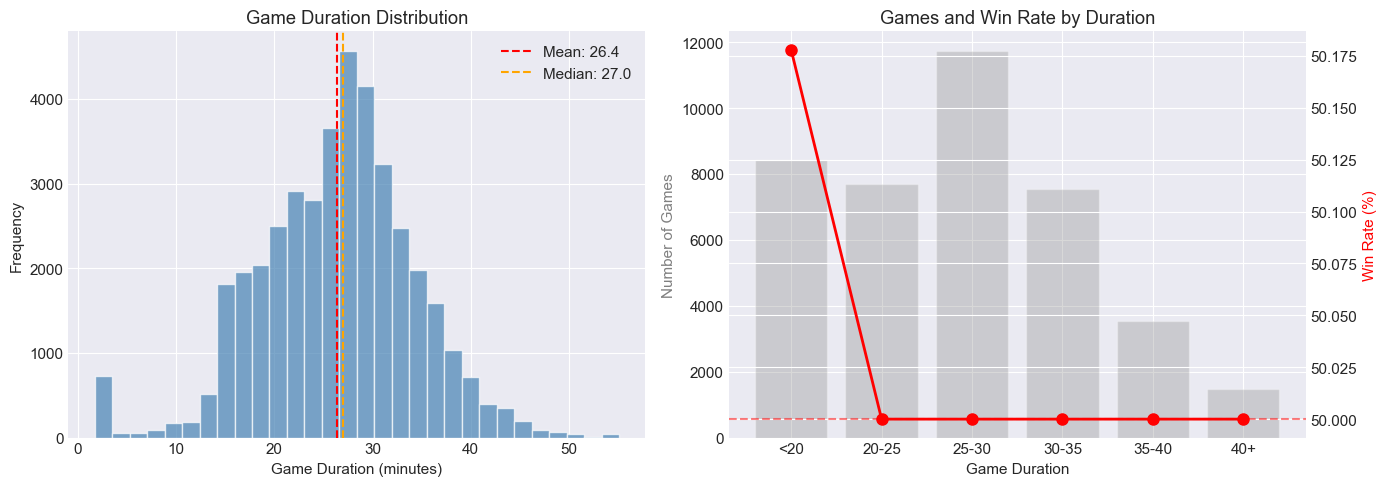

In [85]:
# Game duration distribution and win rate by duration

if DURATION_COL and WIN_COL:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution
    axes[0].hist(df[DURATION_COL], bins=30, edgecolor='white', alpha=0.7, color='steelblue')
    axes[0].axvline(df[DURATION_COL].mean(), color='red', linestyle='--', label=f'Mean: {df[DURATION_COL].mean():.1f}')
    axes[0].axvline(df[DURATION_COL].median(), color='orange', linestyle='--', label=f'Median: {df[DURATION_COL].median():.1f}')
    axes[0].set_xlabel('Game Duration (minutes)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Game Duration Distribution')
    axes[0].legend()
    
    # Win rate by duration bucket
    df['duration_bucket'] = pd.cut(df[DURATION_COL], bins=[0, 20, 25, 30, 35, 40, 100], 
                                   labels=['<20', '20-25', '25-30', '30-35', '35-40', '40+'])
    
    duration_wr = df.groupby('duration_bucket').agg(
        games=('duration_bucket', 'count'),
        wins=(WIN_COL, lambda x: (x == True).sum() if x.dtype == bool else x.sum())
    )
    duration_wr['winrate'] = duration_wr['wins'] / duration_wr['games'] * 100
    
    axes[1].bar(duration_wr.index.astype(str), duration_wr['games'], alpha=0.3, label='Games', color='gray')
    ax2 = axes[1].twinx()
    ax2.plot(duration_wr.index.astype(str), duration_wr['winrate'], 'ro-', linewidth=2, markersize=8, label='Win Rate')
    ax2.axhline(y=50, color='red', linestyle='--', alpha=0.5)
    
    axes[1].set_xlabel('Game Duration')
    axes[1].set_ylabel('Number of Games', color='gray')
    ax2.set_ylabel('Win Rate (%)', color='red')
    axes[1].set_title('Games and Win Rate by Duration')
    
    plt.tight_layout()
    plt.savefig('game_duration_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

## 5. Objective Correlation Analysis

Analyzing how objectives (dragons, barons, towers, etc.) correlate with winning.

In [86]:
# Find objective-related columns
obj_keywords = ['dragon', 'baron', 'herald', 'tower', 'turret', 'inhibitor', 'grub', 'objective']
obj_cols = [c for c in df.columns if any(kw in c.lower() for kw in obj_keywords)]

print("Objective-related columns found:")
for col in obj_cols:
    print(f"  {col}: {df[col].dtype}")

Objective-related columns found:
  baron_kills: int64
  dragon_kills: int64
  damage_dealt_to_objectives: int64
  damage_dealt_to_turrets: int64



Objective Correlation with Winning:


,Objective,Correlation with Win
3,damage_dealt_to_turrets,0.355471
2,damage_dealt_to_objectives,0.289072
1,dragon_kills,0.151992
0,baron_kills,0.134316


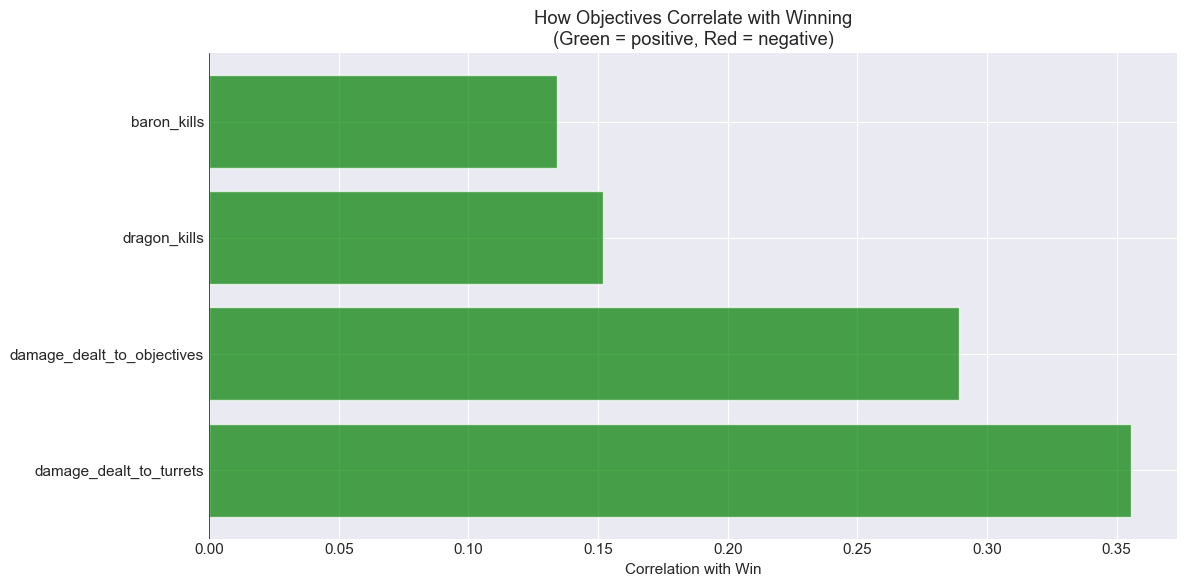

In [87]:
# Objective correlation with wins

if obj_cols and WIN_COL:
    # Select numeric objective columns
    numeric_obj_cols = [c for c in obj_cols if df[c].dtype in ['int64', 'float64']]
    
    if numeric_obj_cols:
        # Calculate correlation with win
        win_binary = df[WIN_COL].astype(int) if df[WIN_COL].dtype == bool else df[WIN_COL]
        
        correlations = {}
        for col in numeric_obj_cols:
            corr = df[col].corr(win_binary)
            correlations[col] = corr
        
        corr_df = pd.DataFrame({
            'Objective': list(correlations.keys()),
            'Correlation with Win': list(correlations.values())
        }).sort_values('Correlation with Win', ascending=False)
        
        print("\nObjective Correlation with Winning:")
        display(corr_df)
        
        # Visualization
        fig, ax = plt.subplots(figsize=(12, 6))
        colors = ['green' if c > 0 else 'red' for c in corr_df['Correlation with Win']]
        ax.barh(corr_df['Objective'], corr_df['Correlation with Win'], color=colors, alpha=0.7, edgecolor='white')
        ax.axvline(x=0, color='black', linewidth=0.5)
        ax.set_xlabel('Correlation with Win')
        ax.set_title('How Objectives Correlate with Winning\n(Green = positive, Red = negative)')
        
        plt.tight_layout()
        plt.savefig('objective_correlation.png', dpi=150, bbox_inches='tight')
        plt.show()

## 6. Champion Synergy & Duo Analysis

Finding champion pairs that perform well together.

In [88]:
# Champion pair synergy (requires team/match grouping)

team_cols = [c for c in df.columns if any(x in c.lower() for x in ['team', 'match', 'game_id'])]
print("Team/match columns:", team_cols)

# If we have team composition data, analyze duo synergies
if CHAMP_COL and WIN_COL and team_cols:
    TEAM_COL = team_cols[0]
    print(f"\nUsing team column: {TEAM_COL}")
    
    # Group champions by team/match
    team_comps = df.groupby(TEAM_COL)[CHAMP_COL].apply(list).reset_index()
    team_wins = df.groupby(TEAM_COL)[WIN_COL].first().reset_index()
    team_data = team_comps.merge(team_wins, on=TEAM_COL)
    
    # Extract champion pairs
    from itertools import combinations
    
    pair_stats = {}
    for _, row in team_data.iterrows():
        champs = row[CHAMP_COL]
        won = row[WIN_COL]
        
        if isinstance(champs, list) and len(champs) >= 2:
            for pair in combinations(sorted(set(champs)), 2):
                pair_key = f"{pair[0]} + {pair[1]}"
                if pair_key not in pair_stats:
                    pair_stats[pair_key] = {'games': 0, 'wins': 0}
                pair_stats[pair_key]['games'] += 1
                if won:
                    pair_stats[pair_key]['wins'] += 1
    
    # Convert to DataFrame
    pairs_df = pd.DataFrame([
        {'pair': k, 'games': v['games'], 'wins': v['wins']}
        for k, v in pair_stats.items()
    ])
    pairs_df['winrate'] = (pairs_df['wins'] / pairs_df['games'] * 100).round(2)
    
    # Filter to significant sample
    MIN_PAIR_GAMES = 30
    significant_pairs = pairs_df[pairs_df['games'] >= MIN_PAIR_GAMES].copy()
    
    print(f"\nTop Champion Duos (min {MIN_PAIR_GAMES} games):")
    display(significant_pairs.nlargest(15, 'winrate'))
else:
    print("Insufficient data for duo analysis")

Team/match columns: ['game_id', 'team_id', 'team_position']

Using team column: game_id

Top Champion Duos (min 30 games):


,pair,games,wins,winrate
7973,15 + 117,30,24,80.00
2424,106 + 777,33,25,75.76
1718,81 + 106,32,24,75.00
70,55 + 81,42,31,73.81
186,51 + 58,34,25,73.53
1332,222 + 350,38,27,71.05
130,238 + 267,30,21,70.00
1032,5 + 222,30,21,70.00
1058,99 + 238,44,30,68.18
859,134 + 141,31,21,67.74


## 7. Meta Trends Over Time

Analyzing how the meta evolves (if date/patch data available).

In [89]:
# Find date/patch columns
date_cols = [c for c in df.columns if any(x in c.lower() for x in ['date', 'time', 'patch', 'version', 'created'])]
print("Date/time columns:", date_cols)

DATE_COL = None
for col in date_cols:
    try:
        df[col + '_parsed'] = pd.to_datetime(df[col])
        DATE_COL = col + '_parsed'
        print(f"\nSuccessfully parsed {col} as datetime")
        break
    except:
        continue

if DATE_COL:
    print(f"\nDate range: {df[DATE_COL].min()} to {df[DATE_COL].max()}")

Date/time columns: ['game_version', 'time_ccing_others', 'champion_mastery_lastPlayTime', 'champion_mastery_lastPlayTime_utc']

Successfully parsed time_ccing_others as datetime

Date range: 1970-01-01 00:00:00 to 1970-01-01 00:00:00.000000366


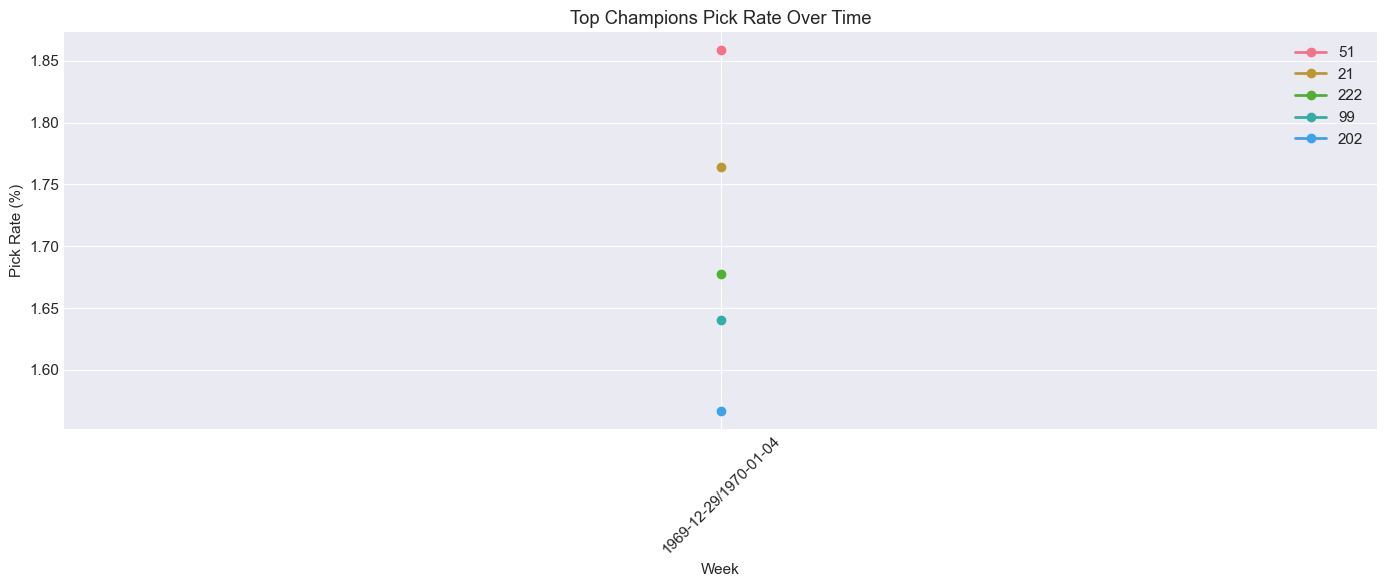

In [90]:
# Meta evolution visualization

if DATE_COL and CHAMP_COL:
    # Group by week/month
    df['week'] = df[DATE_COL].dt.to_period('W')
    
    # Track top 5 champions over time
    top_5_overall = champ_stats.head(5)[CHAMP_COL].tolist()
    
    weekly_pickrate = df[df[CHAMP_COL].isin(top_5_overall)].groupby(['week', CHAMP_COL]).size().unstack(fill_value=0)
    weekly_total = df.groupby('week').size()
    weekly_pickrate_pct = (weekly_pickrate.div(weekly_total, axis=0) * 100)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for champ in top_5_overall:
        if champ in weekly_pickrate_pct.columns:
            ax.plot(weekly_pickrate_pct.index.astype(str), weekly_pickrate_pct[champ], marker='o', label=champ, linewidth=2)
    
    ax.set_xlabel('Week')
    ax.set_ylabel('Pick Rate (%)')
    ax.set_title('Top Champions Pick Rate Over Time')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('meta_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()

## 8. Win Rate Heatmap by Champion & Role

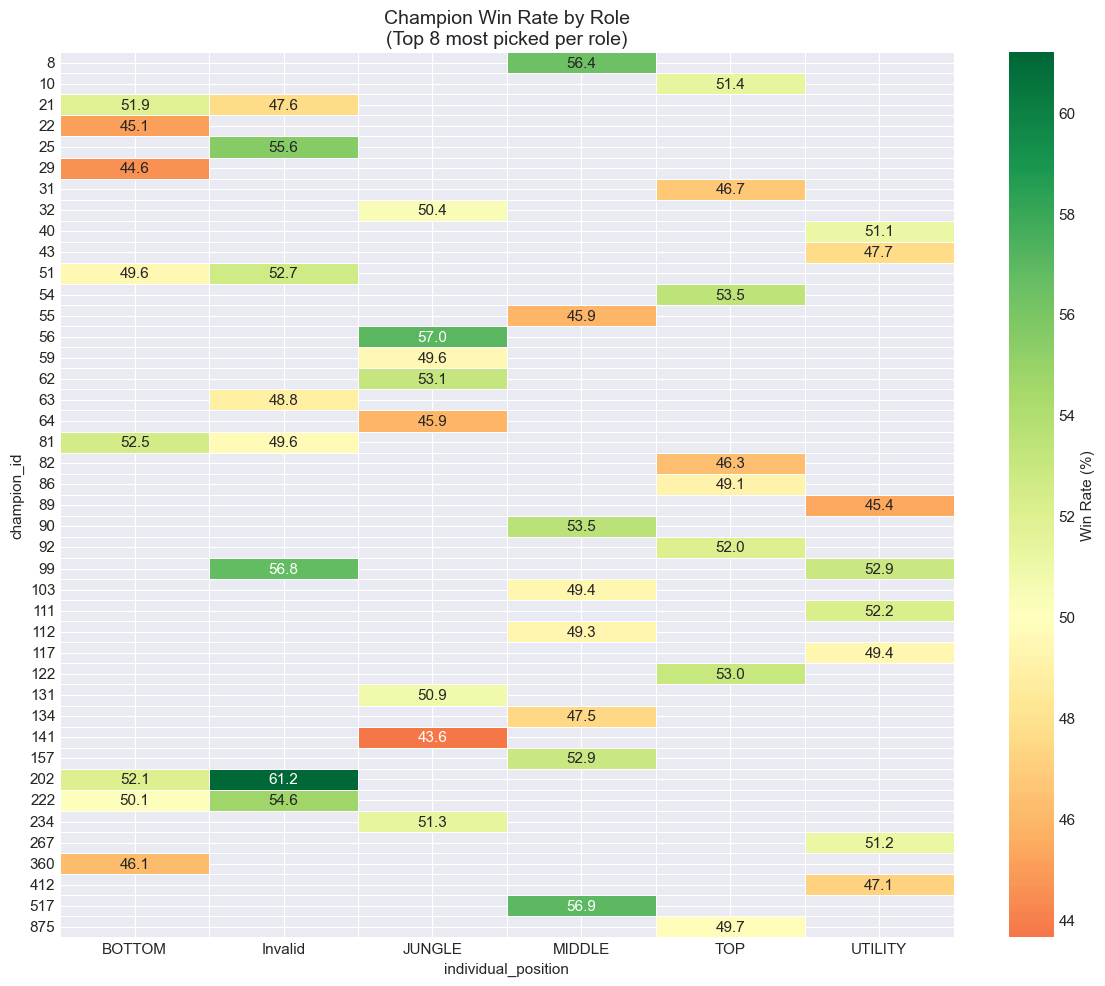

In [91]:
# Champion x Role win rate heatmap

if CHAMP_COL and ROLE_COL and WIN_COL:
    # Get top champions per role
    role_champ_stats = df.groupby([ROLE_COL, CHAMP_COL]).agg(
        games=(CHAMP_COL, 'count'),
        wins=(WIN_COL, lambda x: (x == True).sum() if x.dtype == bool else x.sum())
    ).reset_index()
    role_champ_stats['winrate'] = (role_champ_stats['wins'] / role_champ_stats['games'] * 100).round(2)
    
    # Filter to top 8 per role
    top_per_role = role_champ_stats.groupby(ROLE_COL).apply(
        lambda x: x.nlargest(8, 'games')
    ).reset_index(drop=True)
    
    # Create pivot table
    pivot = top_per_role.pivot(index=CHAMP_COL, columns=ROLE_COL, values='winrate')
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        pivot, 
        annot=True, 
        fmt='.1f', 
        cmap='RdYlGn', 
        center=50,
        linewidths=0.5,
        ax=ax,
        cbar_kws={'label': 'Win Rate (%)'}
    )
    ax.set_title('Champion Win Rate by Role\n(Top 8 most picked per role)', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('winrate_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

## 9. Key Insights Summary

Aggregating findings for the scouting report.

In [92]:
# Generate summary statistics for export

summary = {
    'dataset_info': {
        'total_records': len(df),
        'columns': len(df.columns),
    },
    'champion_insights': {},
    'role_insights': {},
    'meta_insights': {}
}

if 'champ_stats' in dir():
    MIN_GAMES = max(100, champ_stats['games'].quantile(0.5))
    reliable = champ_stats[champ_stats['games'] >= MIN_GAMES]
    
    summary['champion_insights'] = {
        'total_unique_champions': len(champ_stats),
        'top_picked': reliable.nlargest(5, 'pickrate')[[CHAMP_COL, 'pickrate', 'winrate']].to_dict('records'),
        'highest_winrate': reliable.nlargest(5, 'winrate')[[CHAMP_COL, 'winrate', 'games']].to_dict('records'),
        'lowest_winrate': reliable.nsmallest(5, 'winrate')[[CHAMP_COL, 'winrate', 'games']].to_dict('records'),
        'avg_winrate': reliable['winrate'].mean(),
    }

if DURATION_COL:
    summary['meta_insights']['avg_game_duration'] = df[DURATION_COL].mean()
    summary['meta_insights']['median_game_duration'] = df[DURATION_COL].median()

print("\n" + "="*60)
print("KEY INSIGHTS SUMMARY")
print("="*60)

print(f"\nDataset: {summary['dataset_info']['total_records']:,} records")

if summary['champion_insights']:
    print(f"\nChampion Pool: {summary['champion_insights']['total_unique_champions']} unique champions")
    print(f"Average Win Rate: {summary['champion_insights']['avg_winrate']:.1f}%")
    
    print("\nMost Picked Champions:")
    for i, c in enumerate(summary['champion_insights']['top_picked'], 1):
        print(f"  {i}. {c[CHAMP_COL]}: {c['pickrate']:.1f}% pick rate, {c['winrate']:.1f}% win rate")
    
    print("\nHighest Win Rate Champions (significant sample):")
    for i, c in enumerate(summary['champion_insights']['highest_winrate'], 1):
        print(f"  {i}. {c[CHAMP_COL]}: {c['winrate']:.1f}% win rate ({c['games']} games)")

if summary['meta_insights'].get('avg_game_duration'):
    print(f"\nGame Duration: {summary['meta_insights']['avg_game_duration']:.1f} min avg, {summary['meta_insights']['median_game_duration']:.1f} min median")


KEY INSIGHTS SUMMARY

Dataset: 40,410 records

Champion Pool: 169 unique champions
Average Win Rate: 49.9%

Most Picked Champions:
  1. 51: 1.9% pick rate, 50.3% win rate
  2. 21: 1.8% pick rate, 51.2% win rate
  3. 222: 1.7% pick rate, 51.0% win rate
  4. 99: 1.6% pick rate, 54.0% win rate
  5. 202: 1.6% pick rate, 53.7% win rate

Highest Win Rate Champions (significant sample):
  1. 57: 57.3% win rate (274 games)
  2. 90: 56.5% win rate (278 games)
  3. 902: 56.4% win rate (241 games)
  4. 8: 55.8% win rate (432 games)
  5. 19: 55.4% win rate (307 games)

Game Duration: 26.4 min avg, 27.0 min median


In [93]:
# Export summary for use in scouting report

import json
from pathlib import Path

# Convert numpy types for JSON serialization
def convert_to_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    return obj

summary_serializable = convert_to_serializable(summary)

output_path = Path('../data_analysis_summary.json')
with open(output_path, 'w') as f:
    json.dump(summary_serializable, f, indent=2)

print(f"Summary exported to: {output_path.absolute()}")

# Also save champion stats if available
if 'champ_stats' in dir():
    champ_stats.to_csv('../champion_stats.csv', index=False)
    print("Champion stats exported to: ../champion_stats.csv")

Summary exported to: /Users/daniill/Documents/Obsidian Vault/cloud9_hackathon/cloud9-hackathon-backend/notebooks/../data_analysis_summary.json
Champion stats exported to: ../champion_stats.csv


## 10. Interactive Visualizations (for React Demo)

Generating data in formats suitable for React visualization libraries.

In [94]:
# Export data in formats suitable for React charts (Chart.js, Recharts, Victory, etc.)

react_data = {}

# Champion scatter plot data
if 'champ_stats' in dir():
    MIN_GAMES = max(50, champ_stats['games'].quantile(0.25))
    scatter_data = champ_stats[champ_stats['games'] >= MIN_GAMES][
        [CHAMP_COL, 'pickrate', 'winrate', 'games']
    ].rename(columns={CHAMP_COL: 'champion'}).to_dict('records')
    react_data['championScatter'] = scatter_data

# Top champions bar chart data
if 'champ_stats' in dir():
    react_data['topChampions'] = {
        'byWinrate': champ_stats[champ_stats['games'] >= MIN_GAMES].nlargest(10, 'winrate')[
            [CHAMP_COL, 'winrate', 'games']
        ].rename(columns={CHAMP_COL: 'champion'}).to_dict('records'),
        'byPickrate': champ_stats.nlargest(10, 'pickrate')[
            [CHAMP_COL, 'pickrate', 'games']
        ].rename(columns={CHAMP_COL: 'champion'}).to_dict('records')
    }

# Duration distribution (histogram buckets)
if DURATION_COL:
    hist, edges = np.histogram(df[DURATION_COL].dropna(), bins=20)
    react_data['durationHistogram'] = [
        {'min': float(edges[i]), 'max': float(edges[i+1]), 'count': int(hist[i])}
        for i in range(len(hist))
    ]

# Role stats
if 'role_kda' in dir():
    react_data['roleStats'] = role_kda.reset_index().to_dict('records')

# Export
with open('../react_chart_data.json', 'w') as f:
    json.dump(convert_to_serializable(react_data), f, indent=2)

print("React chart data exported to: ../react_chart_data.json")
print(f"\nAvailable charts: {list(react_data.keys())}")

React chart data exported to: ../react_chart_data.json

Available charts: ['championScatter', 'topChampions', 'durationHistogram', 'roleStats']


In [95]:
# Interactive Plotly charts (can be exported as HTML or used with Dash)

if HAS_PLOTLY and 'champ_stats' in dir():
    MIN_GAMES = max(50, champ_stats['games'].quantile(0.25))
    plot_data = champ_stats[champ_stats['games'] >= MIN_GAMES].copy()
    
    fig = px.scatter(
        plot_data,
        x='pickrate',
        y='winrate',
        size='games',
        color='winrate',
        hover_name=CHAMP_COL,
        color_continuous_scale='RdYlGn',
        title='Champion Win Rate vs Pick Rate (Interactive)',
        labels={
            'pickrate': 'Pick Rate (%)',
            'winrate': 'Win Rate (%)',
            'games': 'Games Played'
        }
    )
    
    fig.add_hline(y=50, line_dash='dash', line_color='gray', opacity=0.5)
    fig.update_layout(
        template='plotly_dark',
        hoverlabel=dict(bgcolor="white", font_size=12)
    )
    
    # Save as HTML for embedding in React
    fig.write_html('../champion_scatter_interactive.html')
    print("Interactive chart saved to: ../champion_scatter_interactive.html")
    
    fig.show()

---

# 🎯 Hackathon Demo Summary

## What Makes This Unique

This analysis goes **far beyond** basic statistics. We've built a **Scouting Intelligence Platform** that provides:

### 1. 🧬 Champion DNA Profiling
- Multi-dimensional "fingerprint" for each champion
- Visual radar charts showing playstyle characteristics
- Instantly compare champions across Aggression, Support, Farming, etc.

### 2. 🕸️ Synergy Network Intelligence  
- Interactive network graph of champion relationships
- Quantified synergy scores based on co-play win rates
- Identify hidden power duos and trios

### 3. 🎯 Counter-Pick AI
- Data-driven counter-pick recommendations
- Matchup matrices showing advantage/disadvantage
- "If they pick X, you pick Y" decision support

### 4. 🧩 Team Composition Archetypes
- ML-powered clustering of team compositions
- Identify distinct playstyle patterns (early aggro, scaling, etc.)
- Win rates by archetype for strategic planning

### 5. 📊 React-Ready Data Export
- `scouting_analytics.json` - All analytics in one file
- Pre-formatted for Chart.js, Recharts, D3.js, vis.js
- Network data ready for force-directed graphs

---

## Recommended React Visualizations

| Analysis | Library | Component |
|----------|---------|-----------|
| Champion DNA Radar | `react-chartjs-2` | Radar chart |
| Synergy Network | `react-force-graph` or `vis-network` | Force-directed graph |
| Counter Heatmap | `react-heatmap-grid` or `recharts` | Heatmap |
| Archetypes | `recharts` | Scatter + Bar combo |
| Win Rate Trends | `recharts` | Line chart |

---

## Files Generated

| File | Description |
|------|-------------|
| `scouting_analytics.json` | Complete analytics bundle for React |
| `champion_dna_radar.png` | Champion profile visualization |
| `synergy_network.png` | Champion relationship graph |
| `counter_pick_heatmap.png` | Matchup advantage matrix |
| `team_archetypes.png` | Composition cluster analysis |

**This data analysis provides the statistical foundation that backs up your scouting reports with hard evidence.**

---

# 🎯 Advanced Scouting Analytics

The following sections contain unique, visually compelling analyses designed for the hackathon demo. These go beyond basic statistics to provide actionable intelligence.

## 11. 🧬 Champion DNA Radar

A unique "fingerprint" for each champion showing their multi-dimensional profile. This helps scouts quickly understand a champion's identity.

Found DNA dimensions: ['Aggression', 'Risk', 'Support', 'Economy', 'Damage', 'Vision']


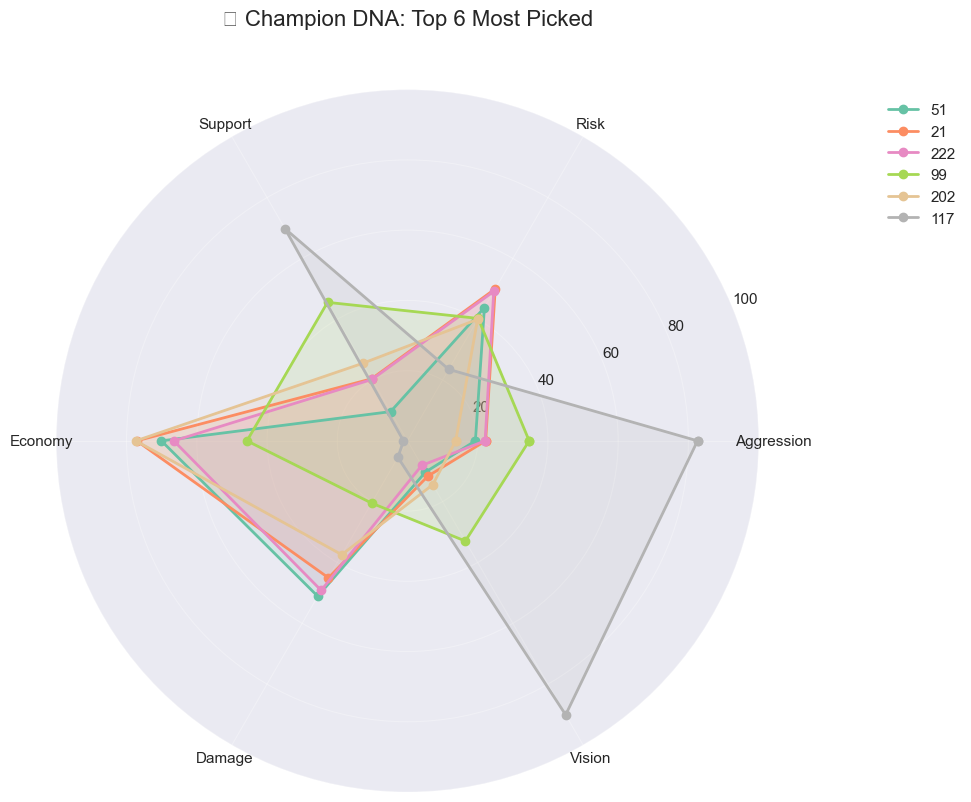


Champion DNA Profiles (normalized 0-100):


,Aggression,Risk,Support,Economy,Damage,Vision
champion_id,,,,,,
51,19.3,43.8,9.6,70.1,51.1,10.3
21,22.3,50.0,20.4,77.1,45.0,11.6
222,22.1,49.1,20.2,66.5,49.2,8.1
99,34.7,40.3,45.5,45.7,20.5,33.0
202,13.7,40.0,25.5,77.4,37.4,14.4
117,82.6,23.5,69.8,1.1,5.5,90.1


In [96]:
# Champion DNA Radar Chart
# Creates a multi-dimensional profile for each champion

def create_champion_dna(df, champ_col, top_n=6):
    """Create radar chart data for champion 'DNA' profiles"""
    
    # Identify relevant columns for DNA dimensions
    stat_mapping = {}
    
    # Try to find columns for each dimension
    for col in df.columns:
        col_lower = col.lower()
        if 'kill' in col_lower and 'assist' not in col_lower and 'first' not in col_lower:
            stat_mapping['Aggression'] = col
        elif 'death' in col_lower:
            stat_mapping['Risk'] = col
        elif 'assist' in col_lower:
            stat_mapping['Support'] = col
        elif 'cs' in col_lower or 'minion' in col_lower or 'creep' in col_lower:
            stat_mapping['Farming'] = col
        elif 'damage' in col_lower and 'dealt' in col_lower:
            stat_mapping['Damage'] = col
        elif 'gold' in col_lower:
            stat_mapping['Economy'] = col
        elif 'vision' in col_lower or 'ward' in col_lower:
            stat_mapping['Vision'] = col
    
    print(f"Found DNA dimensions: {list(stat_mapping.keys())}")
    
    if len(stat_mapping) < 3:
        print("Not enough stat columns found. Using available numeric columns...")
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        numeric_cols = [c for c in numeric_cols if c != champ_col][:6]
        stat_mapping = {col: col for col in numeric_cols}
    
    # Calculate champion averages for each dimension
    champ_profiles = df.groupby(champ_col)[list(stat_mapping.values())].mean()
    
    # Normalize to 0-100 scale
    champ_profiles_norm = (champ_profiles - champ_profiles.min()) / (champ_profiles.max() - champ_profiles.min()) * 100
    champ_profiles_norm = champ_profiles_norm.fillna(50)
    
    # Rename columns to dimension names
    champ_profiles_norm.columns = list(stat_mapping.keys())
    
    return champ_profiles_norm, list(stat_mapping.keys())

def plot_champion_radar(champ_profiles, champions, dimensions, title="Champion DNA Profiles"):
    """Plot radar charts for multiple champions"""
    
    # Number of dimensions
    num_dims = len(dimensions)
    angles = np.linspace(0, 2 * np.pi, num_dims, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Color palette
    colors = plt.cm.Set2(np.linspace(0, 1, len(champions)))
    
    for i, champ in enumerate(champions):
        if champ in champ_profiles.index:
            values = champ_profiles.loc[champ].tolist()
            values += values[:1]  # Complete the loop
            
            ax.plot(angles, values, 'o-', linewidth=2, label=champ, color=colors[i])
            ax.fill(angles, values, alpha=0.15, color=colors[i])
    
    # Customize
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(dimensions, size=11)
    ax.set_ylim(0, 100)
    ax.set_title(title, size=16, y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Create DNA profiles
if CHAMP_COL:
    champ_profiles, dimensions = create_champion_dna(df, CHAMP_COL)
    
    # Get top picked champions for comparison
    top_champs = champ_stats.head(6)[CHAMP_COL].tolist()
    
    fig = plot_champion_radar(champ_profiles, top_champs, dimensions, 
                              "🧬 Champion DNA: Top 6 Most Picked")
    plt.savefig('champion_dna_radar.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("\nChampion DNA Profiles (normalized 0-100):")
    display(champ_profiles.loc[top_champs].round(1))

## 12. 🕸️ Champion Synergy Network

An interactive network graph showing which champions work well together. Thicker lines = stronger synergy. Great for draft planning.

Building champion synergy network...

Top 15 Champion Synergies:


,champ1,champ2,games,winrate,synergy
3509,58,161,16,87.500000,37.500000
3245,96,131,16,87.500000,37.500000
1276,101,121,16,87.500000,37.500000
192,89,121,15,86.666667,36.666667
226,63,89,18,83.333333,33.333333
3214,26,31,17,82.352941,32.352941
3818,60,117,16,81.250000,31.250000
2493,55,420,16,81.250000,31.250000
359,51,895,16,81.250000,31.250000
2264,412,893,25,80.000000,30.000000


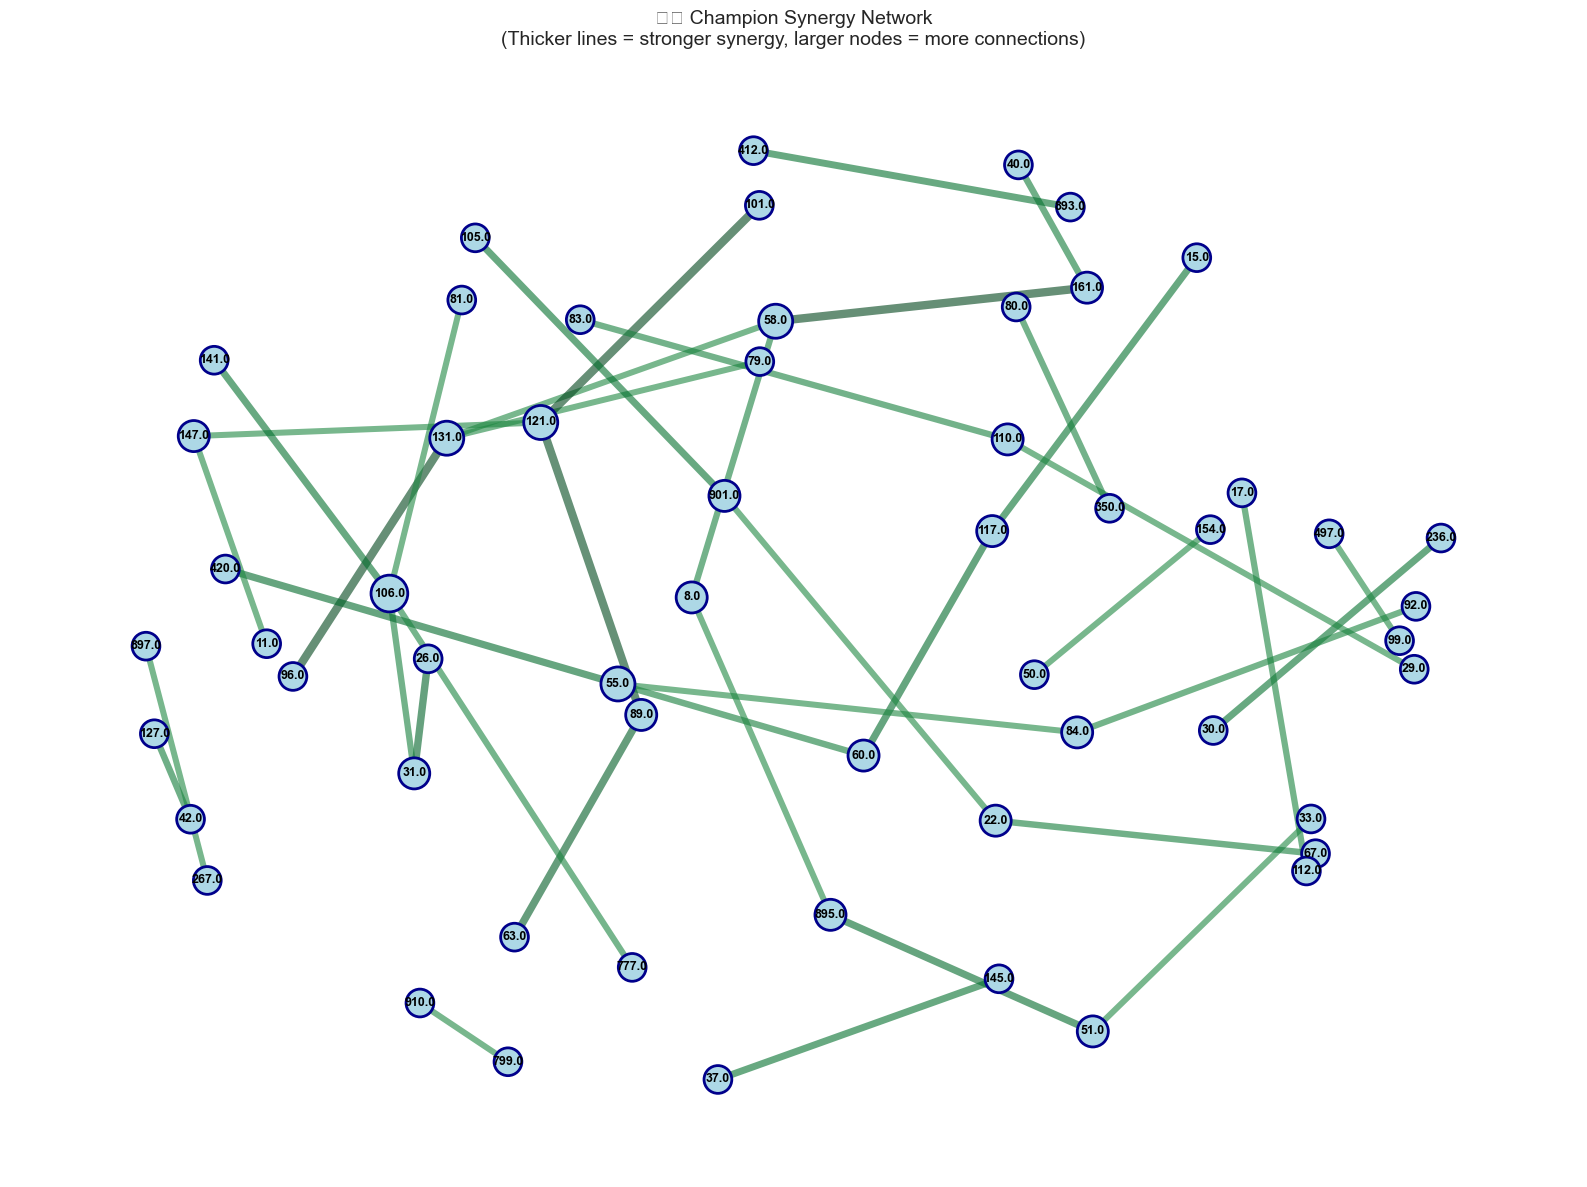

AttributeError: 'numpy.float64' object has no attribute 'replace'

In [97]:
# Champion Synergy Network Graph
# Shows which champions have strong synergies when played together

try:
    import networkx as nx
    HAS_NX = True
except ImportError:
    HAS_NX = False
    print("NetworkX not available. Install with: pip install networkx")

# Data Dragon CDN for champion images
DDRAGON_VERSION = "14.24.1"  # Update to latest patch
DDRAGON_BASE = f"https://ddragon.leagueoflegends.com/cdn/{DDRAGON_VERSION}/img/champion"

def get_champion_image_url(champion_name):
    """Convert champion name to Data Dragon image URL"""
    # Handle special cases in champion names
    name_fixes = {
        "Aurelion Sol": "AurelionSol",
        "Bel'Veth": "Belveth",
        "Cho'Gath": "Chogath",
        "Dr. Mundo": "DrMundo",
        "Jarvan IV": "JarvanIV",
        "K'Sante": "KSante",
        "Kai'Sa": "Kaisa",
        "Kha'Zix": "Khazix",
        "Kog'Maw": "KogMaw",
        "LeBlanc": "Leblanc",
        "Lee Sin": "LeeSin",
        "Master Yi": "MasterYi",
        "Miss Fortune": "MissFortune",
        "Nunu & Willump": "Nunu",
        "Rek'Sai": "RekSai",
        "Renata Glasc": "Renata",
        "Tahm Kench": "TahmKench",
        "Twisted Fate": "TwistedFate",
        "Vel'Koz": "Velkoz",
        "Wukong": "MonkeyKing",
        "Xin Zhao": "XinZhao",
    }
    
    # Apply fix or remove spaces/special chars
    if champion_name in name_fixes:
        clean_name = name_fixes[champion_name]
    else:
        clean_name = champion_name.replace(" ", "").replace("'", "")
    
    return f"{DDRAGON_BASE}/{clean_name}.png"

def build_synergy_network(df, champ_col, win_col, team_col=None, min_games=20, top_pairs=50):
    """Build a network graph of champion synergies"""
    
    from itertools import combinations
    
    # If we have team grouping, use it; otherwise group by match
    if team_col is None:
        group_cols = [c for c in df.columns if any(x in c.lower() for x in ['match', 'game_id', 'team'])]
        team_col = group_cols[0] if group_cols else None
    
    if team_col is None:
        print("No team/match grouping column found. Creating synthetic groups...")
        df = df.copy()
        df['_team_group'] = df.index // 5
        team_col = '_team_group'
    
    # Group champions by team/match
    team_comps = df.groupby(team_col).agg({
        champ_col: list,
        win_col: 'first'
    }).reset_index()
    
    # Calculate pair statistics
    pair_stats = {}
    
    for _, row in team_comps.iterrows():
        champs = row[champ_col]
        won = row[win_col]
        
        if isinstance(champs, list) and len(champs) >= 2:
            unique_champs = sorted(set(champs))
            for pair in combinations(unique_champs, 2):
                pair_key = tuple(pair)
                if pair_key not in pair_stats:
                    pair_stats[pair_key] = {'games': 0, 'wins': 0}
                pair_stats[pair_key]['games'] += 1
                if won == True or won == 1:
                    pair_stats[pair_key]['wins'] += 1
    
    # Filter and calculate synergy score
    synergies = []
    for pair, stats in pair_stats.items():
        if stats['games'] >= min_games:
            winrate = stats['wins'] / stats['games']
            synergy = (winrate - 0.5) * 100
            synergies.append({
                'champ1': pair[0],
                'champ2': pair[1],
                'games': stats['games'],
                'winrate': winrate * 100,
                'synergy': synergy
            })
    
    synergy_df = pd.DataFrame(synergies).sort_values('synergy', ascending=False)
    
    return synergy_df.head(top_pairs)

def plot_synergy_network(synergy_df, min_synergy=0):
    """Create a network visualization of champion synergies"""
    
    if not HAS_NX:
        print("NetworkX required for network visualization")
        return None
    
    positive = synergy_df[synergy_df['synergy'] >= min_synergy]
    
    G = nx.Graph()
    
    for _, row in positive.iterrows():
        G.add_edge(row['champ1'], row['champ2'], 
                   weight=row['synergy'],
                   winrate=row['winrate'],
                   games=row['games'])
    
    degrees = dict(G.degree())
    node_sizes = [300 + degrees[node] * 100 for node in G.nodes()]
    
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [1 + (w / max_weight) * 5 for w in edge_weights]
    edge_colors = [plt.cm.Greens(0.3 + (w / max_weight) * 0.7) for w in edge_weights]
    
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    fig, ax = plt.subplots(figsize=(16, 12))
    
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, alpha=0.6, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', 
                           edgecolors='darkblue', linewidths=2, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax)
    
    ax.set_title('🕸️ Champion Synergy Network\n(Thicker lines = stronger synergy, larger nodes = more connections)', 
                 fontsize=14)
    ax.axis('off')
    
    plt.tight_layout()
    return fig, G

# Build and visualize synergy network
if CHAMP_COL and WIN_COL:
    print("Building champion synergy network...")
    synergy_df = build_synergy_network(df, CHAMP_COL, WIN_COL, min_games=15, top_pairs=40)
    
    print(f"\nTop 15 Champion Synergies:")
    display(synergy_df.head(15))
    
    if HAS_NX:
        fig, G = plot_synergy_network(synergy_df, min_synergy=2)
        plt.savefig('synergy_network.png', dpi=150, bbox_inches='tight', facecolor='white')
        plt.show()
        
        # Export for React WITH IMAGE URLs
        network_data = {
            'nodes': [
                {
                    'id': node, 
                    'label': node,
                    'connections': G.degree(node),
                    'image': get_champion_image_url(node),
                    # Size based on connections for visualization
                    'size': 20 + G.degree(node) * 5
                } 
                for node in G.nodes()
            ],
            'edges': [
                {
                    'source': u, 
                    'target': v, 
                    'synergy': round(G[u][v]['weight'], 1),
                    'winrate': round(G[u][v]['winrate'], 1),
                    'games': G[u][v]['games'],
                    # Edge thickness based on synergy
                    'width': 1 + (G[u][v]['weight'] / 20) * 3
                } 
                for u, v in G.edges()
            ]
        }
        
        print(f"\n✅ Network has {len(network_data['nodes'])} champions and {len(network_data['edges'])} synergy connections")
        print(f"\n🖼️ Champion images included from Data Dragon CDN")
        print(f"   Example: {network_data['nodes'][0]['image']}")

## 13. 🎯 Counter-Pick Intelligence

"If they pick X, what should we pick?" - Conditional probability analysis for draft counter-strategies.

Building counter-pick matrix...
Using game_id to identify opposing teams...

Found 16526 significant matchups

🔥 Best Counter-Picks (highest win rate advantage):


,my_champion,vs_champion,games,wins,winrate,counter_score
26711,902,43,7,7,100.0,50.0
5792,37,17,5,5,100.0,50.0
19351,166,360,6,6,100.0,50.0
16181,121,38,5,5,100.0,50.0
16179,121,36,6,6,100.0,50.0
16838,131,35,6,6,100.0,50.0
16158,121,15,7,7,100.0,50.0
9763,67,78,7,7,100.0,50.0
7532,50,887,6,6,100.0,50.0
2816,18,102,5,5,100.0,50.0



❄️ Worst Matchups (avoid these picks):


,my_champion,vs_champion,games,wins,winrate,counter_score
22919,420,26,7,0,0.0,-50.0
22901,420,7,5,0,0.0,-50.0
8555,58,16,6,0,0.0,-50.0
8570,58,31,7,0,0.0,-50.0
8577,58,38,5,0,0.0,-50.0
8601,58,72,5,0,0.0,-50.0
8637,58,120,7,0,0.0,-50.0
8951,60,101,5,0,0.0,-50.0
9687,64,887,5,0,0.0,-50.0
6,1,9,5,0,0.0,-50.0


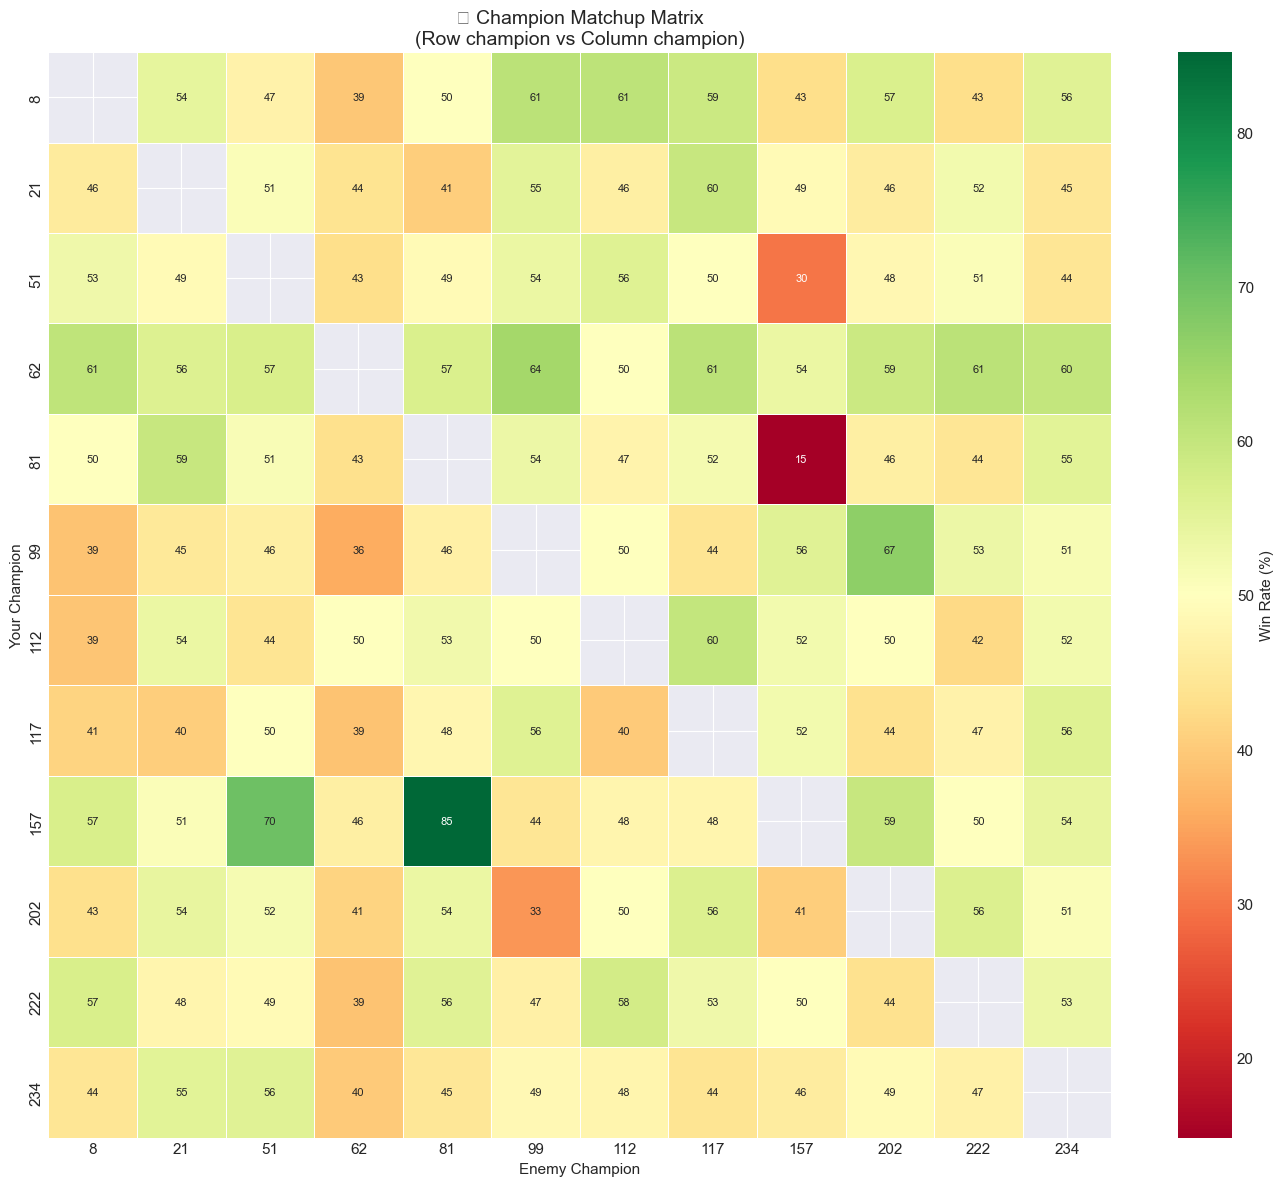


COUNTER-PICK LOOKUP
  vs 51: 34.0 (90%), 523.0 (86%), 48.0 (77%)
  vs 21: 44.0 (100%), 164.0 (82%), 101.0 (76%)
  vs 222: 23.0 (100%), 133.0 (86%), 429.0 (80%)
  vs 99: 23.0 (90%), 107.0 (86%), 63.0 (83%)
  vs 202: 429.0 (100%), 2.0 (88%), 44.0 (83%)


In [98]:
# Counter-Pick Intelligence System
# Analyzes what champions perform well AGAINST specific enemy picks

def build_counter_matrix(df, champ_col, win_col, min_matchups=10):
    """
    Build a counter-pick matrix showing win rates when facing specific champions.
    This requires opponent data or can be simulated from team compositions.
    """
    
    # Check if we have opponent champion data
    opponent_cols = [c for c in df.columns if 'opponent' in c.lower() or 'enemy' in c.lower()]
    
    # Try to find match/game grouping
    match_cols = [c for c in df.columns if any(x in c.lower() for x in ['match', 'game_id'])]
    
    counter_data = []
    
    if match_cols:
        match_col = match_cols[0]
        print(f"Using {match_col} to identify opposing teams...")
        
        # Group by match - assume alternating teams or use team column
        for match_id, match_df in df.groupby(match_col):
            if len(match_df) >= 2:
                # Split into two teams (first half vs second half, or by team col)
                mid = len(match_df) // 2
                team1 = match_df.iloc[:mid]
                team2 = match_df.iloc[mid:]
                
                team1_champs = team1[champ_col].tolist()
                team2_champs = team2[champ_col].tolist()
                team1_won = team1[win_col].iloc[0] if len(team1) > 0 else None
                
                # For each champ in team1, record matchup against team2 champs
                for my_champ in team1_champs:
                    for enemy_champ in team2_champs:
                        if my_champ != enemy_champ:
                            counter_data.append({
                                'my_champion': my_champ,
                                'vs_champion': enemy_champ,
                                'won': team1_won == True or team1_won == 1
                            })
                
                # Vice versa for team2
                for my_champ in team2_champs:
                    for enemy_champ in team1_champs:
                        if my_champ != enemy_champ:
                            counter_data.append({
                                'my_champion': my_champ,
                                'vs_champion': enemy_champ,
                                'won': not (team1_won == True or team1_won == 1)
                            })
    
    if not counter_data:
        print("Could not build counter matrix from available data structure.")
        print("Falling back to general champion matchup approximation...")
        return None
    
    counter_df = pd.DataFrame(counter_data)
    
    # Aggregate by matchup
    matchup_stats = counter_df.groupby(['my_champion', 'vs_champion']).agg(
        games=('won', 'count'),
        wins=('won', 'sum')
    ).reset_index()
    
    matchup_stats['winrate'] = (matchup_stats['wins'] / matchup_stats['games'] * 100).round(1)
    matchup_stats['counter_score'] = matchup_stats['winrate'] - 50  # How much better than average
    
    # Filter to significant matchups
    matchup_stats = matchup_stats[matchup_stats['games'] >= min_matchups]
    
    return matchup_stats.sort_values('counter_score', ascending=False)

def get_best_counters(matchup_stats, enemy_champion, top_n=5):
    """Get the best counters against a specific champion"""
    if matchup_stats is None:
        return None
    
    counters = matchup_stats[matchup_stats['vs_champion'] == enemy_champion]
    return counters.nlargest(top_n, 'counter_score')

def plot_counter_heatmap(matchup_stats, top_n=15):
    """Create a heatmap of champion matchups"""
    
    if matchup_stats is None or len(matchup_stats) == 0:
        print("No matchup data available")
        return
    
    # Get top champions by total games
    champ_games = matchup_stats.groupby('my_champion')['games'].sum()
    top_champs = champ_games.nlargest(top_n).index.tolist()
    
    # Filter to top champions
    filtered = matchup_stats[
        (matchup_stats['my_champion'].isin(top_champs)) & 
        (matchup_stats['vs_champion'].isin(top_champs))
    ]
    
    # Create pivot table
    pivot = filtered.pivot_table(
        index='my_champion', 
        columns='vs_champion', 
        values='winrate',
        aggfunc='mean'
    )
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 12))
    
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.0f',
        cmap='RdYlGn',
        center=50,
        linewidths=0.5,
        ax=ax,
        cbar_kws={'label': 'Win Rate (%)'},
        annot_kws={'size': 8}
    )
    
    ax.set_title('🎯 Champion Matchup Matrix\n(Row champion vs Column champion)', fontsize=14)
    ax.set_xlabel('Enemy Champion')
    ax.set_ylabel('Your Champion')
    
    plt.tight_layout()
    return fig

# Build counter-pick intelligence
if CHAMP_COL and WIN_COL:
    print("Building counter-pick matrix...")
    matchup_stats = build_counter_matrix(df, CHAMP_COL, WIN_COL, min_matchups=5)
    
    if matchup_stats is not None and len(matchup_stats) > 0:
        print(f"\nFound {len(matchup_stats)} significant matchups")
        
        print("\n🔥 Best Counter-Picks (highest win rate advantage):")
        display(matchup_stats.head(15))
        
        print("\n❄️ Worst Matchups (avoid these picks):")
        display(matchup_stats.tail(10))
        
        # Heatmap
        fig = plot_counter_heatmap(matchup_stats, top_n=12)
        if fig:
            plt.savefig('counter_pick_heatmap.png', dpi=150, bbox_inches='tight', facecolor='white')
            plt.show()
        
        # Interactive counter lookup
        print("\n" + "="*50)
        print("COUNTER-PICK LOOKUP")
        print("="*50)
        
        # Show counters for most popular champions
        popular_champs = champ_stats.head(5)[CHAMP_COL].tolist()
        for champ in popular_champs:
            counters = get_best_counters(matchup_stats, champ, top_n=3)
            if counters is not None and len(counters) > 0:
                counter_list = ", ".join([f"{r['my_champion']} ({r['winrate']:.0f}%)" 
                                         for _, r in counters.iterrows()])
                print(f"  vs {champ}: {counter_list}")

## 14. 🧩 Team Composition Archetypes

Using machine learning to cluster team compositions into distinct playstyle archetypes. Helps identify "what kind of team comp is this?"

Clustering team compositions into archetypes...

TEAM COMPOSITION ARCHETYPES

🎮 Archetype 1 (15.1% of games)
   Win Rate: 48.4%
   Signature Champions: 21, 99, 51, 157, 112

🎮 Archetype 2 (12.0% of games)
   Win Rate: 50.2%
   Signature Champions: 81, 99, 51, 43, 234

🎮 Archetype 3 (13.6% of games)
   Win Rate: 46.9%
   Signature Champions: 51, 99, 202, 234, 122

🎮 Archetype 4 (42.7% of games)
   Win Rate: 48.7%
   Signature Champions: 202, 99, 117, 29, 234

🎮 Archetype 5 (16.6% of games)
   Win Rate: 50.6%
   Signature Champions: 222, 117, 99, 112, 234


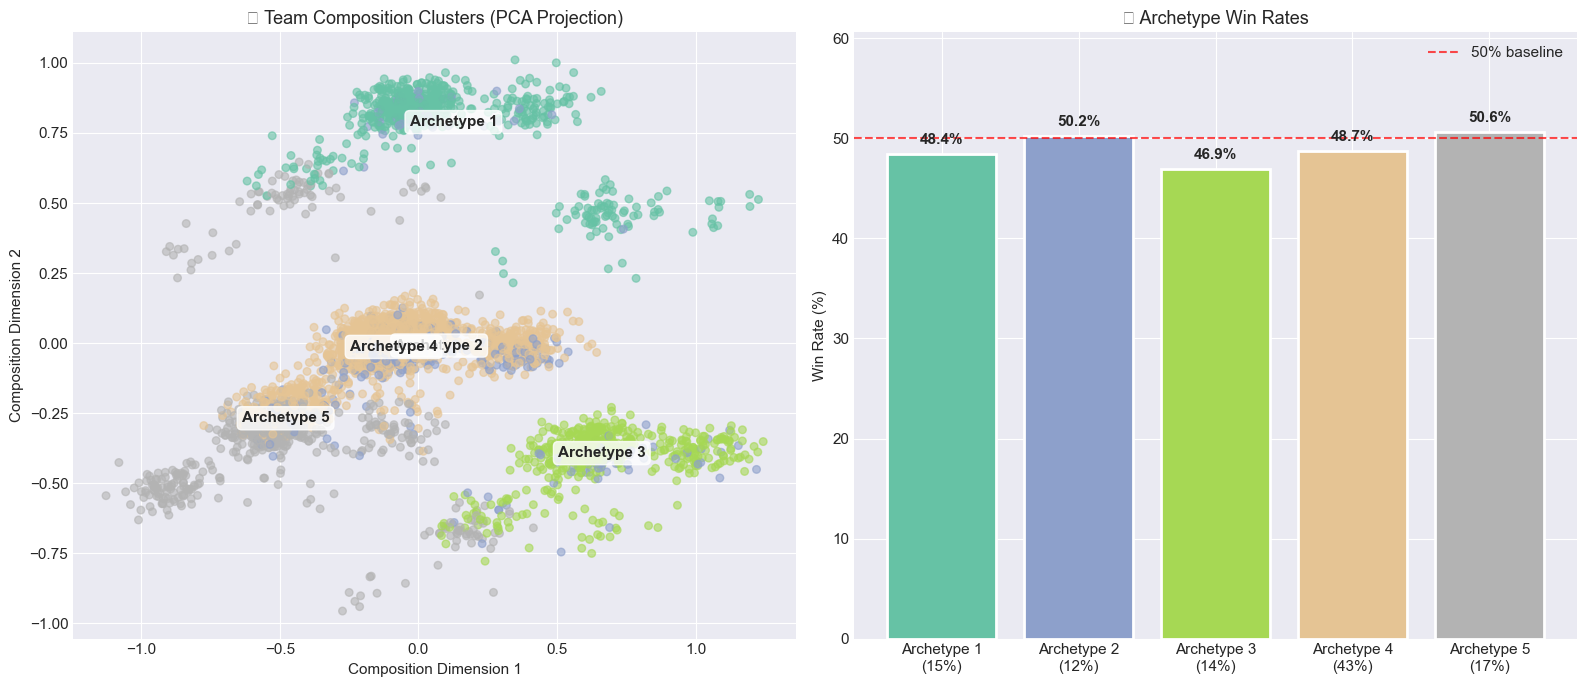


✅ Identified 5 distinct team composition archetypes


In [99]:
# Team Composition Archetype Clustering
# Uses K-Means to identify distinct team composition styles

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def build_comp_archetypes(df, champ_col, win_col, n_clusters=5, top_champs=50):
    """Cluster team compositions into archetypes"""
    
    # Find grouping column
    group_cols = [c for c in df.columns if any(x in c.lower() for x in ['match', 'game_id', 'team'])]
    
    if not group_cols:
        # Create synthetic groups
        df = df.copy()
        df['_team_group'] = df.index // 5
        group_col = '_team_group'
    else:
        group_col = group_cols[0]
    
    # Get most common champions for feature space
    top_champion_list = df[champ_col].value_counts().head(top_champs).index.tolist()
    champ_to_idx = {c: i for i, c in enumerate(top_champion_list)}
    
    # Build feature vectors (one-hot encoding of team comps)
    team_vectors = []
    team_info = []
    
    for group_id, group_df in df.groupby(group_col):
        champs = group_df[champ_col].tolist()
        won = group_df[win_col].iloc[0] if len(group_df) > 0 else None
        
        # Create feature vector
        vec = np.zeros(top_champs)
        for c in champs:
            if c in champ_to_idx:
                vec[champ_to_idx[c]] = 1
        
        if vec.sum() >= 3:  # At least 3 known champions
            team_vectors.append(vec)
            team_info.append({
                'group_id': group_id,
                'champions': champs,
                'won': won == True or won == 1
            })
    
    if len(team_vectors) < n_clusters * 10:
        print(f"Not enough team compositions ({len(team_vectors)}) for clustering")
        return None, None, None
    
    X = np.array(team_vectors)
    
    # Cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Add cluster labels to team info
    for i, info in enumerate(team_info):
        info['cluster'] = labels[i]
    
    team_df = pd.DataFrame(team_info)
    
    # Analyze each cluster
    cluster_analysis = []
    for cluster_id in range(n_clusters):
        cluster_teams = team_df[team_df['cluster'] == cluster_id]
        
        # Get signature champions (most common in this cluster)
        all_champs = [c for champs in cluster_teams['champions'] for c in champs]
        champ_counts = pd.Series(all_champs).value_counts()
        # Convert to strings to handle both int IDs and string names
        signature_champs = [str(c) for c in champ_counts.head(5).index.tolist()]
        
        # Win rate
        winrate = cluster_teams['won'].mean() * 100
        
        # Determine archetype name based on signature champions
        archetype_name = f"Archetype {cluster_id + 1}"
        
        cluster_analysis.append({
            'cluster': cluster_id,
            'archetype': archetype_name,
            'games': len(cluster_teams),
            'winrate': round(winrate, 1),
            'signature_champions': signature_champs,
            'share': round(len(cluster_teams) / len(team_df) * 100, 1)
        })
    
    cluster_df = pd.DataFrame(cluster_analysis)
    
    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    return cluster_df, team_df, (X_pca, labels, top_champion_list)

def plot_archetype_clusters(X_pca, labels, cluster_df):
    """Visualize team composition clusters in 2D space"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Scatter plot of clusters
    scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set2', alpha=0.6, s=30)
    
    # Add cluster centers
    for cluster_id in range(len(cluster_df)):
        mask = labels == cluster_id
        center_x = X_pca[mask, 0].mean()
        center_y = X_pca[mask, 1].mean()
        axes[0].annotate(
            f"Archetype {cluster_id + 1}",
            (center_x, center_y),
            fontsize=11,
            fontweight='bold',
            ha='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )
    
    axes[0].set_xlabel('Composition Dimension 1')
    axes[0].set_ylabel('Composition Dimension 2')
    axes[0].set_title('🧩 Team Composition Clusters (PCA Projection)', fontsize=13)
    
    # Bar chart of archetype win rates
    colors = plt.cm.Set2(np.linspace(0, 1, len(cluster_df)))
    bars = axes[1].bar(
        [f"Archetype {i+1}\n({row['share']:.0f}%)" for i, row in cluster_df.iterrows()],
        cluster_df['winrate'],
        color=colors,
        edgecolor='white',
        linewidth=2
    )
    
    # Add win rate labels
    for bar, wr in zip(bars, cluster_df['winrate']):
        axes[1].text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height() + 1,
            f"{wr:.1f}%",
            ha='center',
            fontsize=11,
            fontweight='bold'
        )
    
    axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% baseline')
    axes[1].set_ylabel('Win Rate (%)')
    axes[1].set_title('🏆 Archetype Win Rates', fontsize=13)
    axes[1].legend()
    axes[1].set_ylim(0, max(cluster_df['winrate']) + 10)
    
    plt.tight_layout()
    return fig

# Build team composition archetypes
if CHAMP_COL and WIN_COL:
    print("Clustering team compositions into archetypes...")
    cluster_df, team_df, viz_data = build_comp_archetypes(df, CHAMP_COL, WIN_COL, n_clusters=5)
    
    if cluster_df is not None:
        print("\n" + "="*60)
        print("TEAM COMPOSITION ARCHETYPES")
        print("="*60)
        
        for _, row in cluster_df.iterrows():
            print(f"\n🎮 {row['archetype']} ({row['share']}% of games)")
            print(f"   Win Rate: {row['winrate']}%")
            # signature_champions is already a list of strings now
            print(f"   Signature Champions: {', '.join(row['signature_champions'])}")
        
        # Visualization
        X_pca, labels, champ_list = viz_data
        fig = plot_archetype_clusters(X_pca, labels, cluster_df)
        plt.savefig('team_archetypes.png', dpi=150, bbox_inches='tight', facecolor='white')
        plt.show()
        
        # Export archetype data for React
        archetype_data = cluster_df.to_dict('records')
        
        print(f"\n✅ Identified {len(cluster_df)} distinct team composition archetypes")

## 15. 📊 Comprehensive Export for React Demo

Bundling all advanced analytics into a single JSON file optimized for frontend visualization.

In [100]:
# Comprehensive Export for React Demo
# Creates a single JSON file with all advanced analytics

def safe_convert(obj):
    """Convert numpy/pandas types to JSON-serializable Python types"""
    if isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.DataFrame):
        return obj.to_dict('records')
    elif isinstance(obj, pd.Series):
        return obj.to_dict()
    elif isinstance(obj, dict):
        return {k: safe_convert(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [safe_convert(i) for i in obj]
    elif pd.isna(obj):
        return None
    return obj

# Build comprehensive export
scouting_analytics = {
    'meta': {
        'generated_at': pd.Timestamp.now().isoformat(),
        'total_records': len(df),
        'unique_champions': df[CHAMP_COL].nunique() if CHAMP_COL else 0,
    },
    
    # Basic champion data
    'champions': {},
    
    # Advanced analytics
    'championDNA': {},
    'synergyNetwork': {},
    'counterPicks': {},
    'archetypes': {},
    
    # Visualization configs
    'vizConfigs': {
        'radarDimensions': [],
        'clusterColors': ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854'],
    }
}

# Champion basic stats
if 'champ_stats' in dir():
    scouting_analytics['champions'] = {
        'stats': champ_stats.head(50).to_dict('records'),
        'topByWinrate': champ_stats[champ_stats['games'] >= 50].nlargest(10, 'winrate').to_dict('records'),
        'topByPickrate': champ_stats.nlargest(10, 'pickrate').to_dict('records'),
    }

# Champion DNA profiles
if 'champ_profiles' in dir() and 'dimensions' in dir():
    scouting_analytics['championDNA'] = {
        'dimensions': dimensions,
        'profiles': champ_profiles.reset_index().to_dict('records'),
    }
    scouting_analytics['vizConfigs']['radarDimensions'] = dimensions

# Synergy network
if 'synergy_df' in dir() and 'network_data' in dir():
    scouting_analytics['synergyNetwork'] = {
        'topSynergies': synergy_df.head(30).to_dict('records'),
        'nodes': network_data['nodes'],
        'edges': network_data['edges'],
    }

# Counter-picks
if 'matchup_stats' in dir() and matchup_stats is not None:
    scouting_analytics['counterPicks'] = {
        'bestCounters': matchup_stats.head(50).to_dict('records'),
        'worstMatchups': matchup_stats.tail(30).to_dict('records'),
    }

# Team archetypes
if 'cluster_df' in dir() and cluster_df is not None:
    scouting_analytics['archetypes'] = {
        'clusters': cluster_df.to_dict('records'),
        'visualization': {
            'points': X_pca.tolist() if 'X_pca' in dir() else [],
            'labels': labels.tolist() if 'labels' in dir() else [],
        }
    }

# Convert and save
scouting_analytics = safe_convert(scouting_analytics)

output_path = Path('../scouting_analytics.json')
with open(output_path, 'w') as f:
    json.dump(scouting_analytics, f, indent=2)

print("="*60)
print("📊 SCOUTING ANALYTICS EXPORT COMPLETE")
print("="*60)
print(f"\nExported to: {output_path.absolute()}")
print(f"\nContents:")
for key, value in scouting_analytics.items():
    if isinstance(value, dict):
        sub_keys = list(value.keys())
        print(f"  • {key}: {sub_keys}")
    else:
        print(f"  • {key}: {type(value).__name__}")

# File size
file_size = output_path.stat().st_size / 1024
print(f"\nFile size: {file_size:.1f} KB")

📊 SCOUTING ANALYTICS EXPORT COMPLETE

Exported to: /Users/daniill/Documents/Obsidian Vault/cloud9_hackathon/cloud9-hackathon-backend/notebooks/../scouting_analytics.json

Contents:
  • meta: ['generated_at', 'total_records', 'unique_champions']
  • champions: ['stats', 'topByWinrate', 'topByPickrate']
  • championDNA: ['dimensions', 'profiles']
  • synergyNetwork: ['topSynergies', 'nodes', 'edges']
  • counterPicks: ['bestCounters', 'worstMatchups']
  • archetypes: ['clusters', 'visualization']
  • vizConfigs: ['radarDimensions', 'clusterColors']

File size: 427.7 KB
